In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import tifffile
import pre_process_mm as pre
import mm3_adapted_cell_segmentation as mm3seg
import mm3_adapted_cell_tracking as mm3track
import plot_cells
from scipy.optimize import curve_fit

In [2]:
# starting at t= 25 for fov 005, fov 018 starting at t = 0

seg_FOV_dict = {'DUMM_giTG62_Glucose_012925': 
            {'005': ['445', '900', '1128', '1277', '1887',  '2115', '2344', '2421', '2497'],
             '018':['1940', '1483']
            }
           }

In [ ]:
phase_channel = '0'
fluor_channel = '1'
for folder, fov_dict in seg_FOV_dict.items():
    for fov_id in fov_dict.keys():
        ana_peak_ids = fov_dict[fov_id]
        for peak_id in ana_peak_ids:
            path_to_phase_stack = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/subtracted_FOV_{fov_id}_region_{peak_id}_c_{phase_channel}.tif'
            path_to_fluor_stack = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/subtracted_FOV_{fov_id}_region_{peak_id}_c_{fluor_channel}.tif'
            output_path = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/outputs'
            mm3seg.segment_chnl_stack(path_to_phase_stack,
                   output_path,
                   OTSU_threshold=1.5,
                   first_opening=2,
                   distance_threshold=1,
                   second_opening_size=1,
                   min_cell_area=200,
				   max_cell_area=600,
                   small_merge_area_threshold=200)
            labeled_stack = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/mm3_segmented_subtracted_FOV_{fov_id}_region_{peak_id}_c_{phase_channel}.tif'
            plot_cells.display_segmentation(path_to_phase_stack, mask_path = labeled_stack, start=28, end=170, alpha=0.5)

# Cell fluorescent intensity is no longer being tracked properly, is it something about the start frame

In [6]:
folder = 'DUMM_giTG62_Glucose_012925'
fov_id = '005'
peak_id = '2497'
phase_channel = '0'
fluor_channel = '1'

In [7]:
path_to_phase_stack = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/subtracted_FOV_{fov_id}_region_{peak_id}_c_{phase_channel}.tif'
path_to_fluor_stack = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/subtracted_FOV_{fov_id}_region_{peak_id}_c_{fluor_channel}.tif'
labeled_stack = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/mm3_segmented_subtracted_FOV_{fov_id}_region_{peak_id}_c_{phase_channel}.tif'

In [8]:
fl_stack = tifffile.imread(path_to_fluor_stack)
seg_stack = tifffile.imread(labeled_stack)

In [9]:
fl_stack.shape

(180, 286, 20)

In [10]:
seg_stack.shape

(180, 286, 20)

In [28]:
cells_dict = mm3track.make_lineage_chnl_stack(labeled_stack = labeled_stack, 
                                              fov_id = int(fov_id), 
                                              peak_id = int(peak_id), 
                                              pxl2um = 1,
                                              start_frame = 28)

In [ ]:
# Loop through cells
for cell in cells_dict.values():
    # give this cell two lists to hold new information
    cell.fl_tots = []  # total fluorescence per time point
    cell.fl_area_avgs = []
    cell.fl_vol_avgs = []  # avg fluorescence per unit volume by timepoint


    # and the time points that make up this cell's life
    for n, t in enumerate(cell.times):
        # create fluorescent image only for this cell and timepoint.
        print(t)

In [ ]:

        fl_image_masked = np.copy(fl_stack[t - start_frame])
        fl_image_masked[seg_stack[t - start_frame] != cell.labels[n]] = 0

        # append total flourescent image
        cell.fl_tots.append(np.sum(fl_image_masked))
        # and the average fluorescence
        cell.fl_area_avgs.append(np.sum(fl_image_masked) / cell.areas[n])
        cell.fl_vol_avgs.append(np.sum(fl_image_masked) / cell.volumes[n])


In [70]:
def find_cell_intensities2(path_to_original_stack,
                          path_to_segmented_stack,
                          cells, start_frame,
                          midline=False):
    """
    Finds fluorescent information for cells. All the cells in cells
    should be from one fov/peak. See the function
    organize_cells_by_channel()
    """

    # Load fluorescent images and segmented images for this microfluidic channel

    fl_stack = tifffile.imread(path_to_original_stack)
    seg_stack = tifffile.imread(path_to_segmented_stack)

    # Loop through cells
    for cell_id, cell in cells.items():
        # give this cell two lists to hold new information
        cell.fl_tots = []  # total fluorescence per time point
        cell.fl_area_avgs = []
        cell.fl_vol_avgs = []  # avg fluorescence per unit volume by timepoint

        if midline:
            cell.mid_fl = []  # avg fluorescence of midline

        # and the time points that make up this cell's life
        for t in cell.times:
            n = cell.times.index(t)
            image = np.copy(fl_stack[t])
            region = cell.regions[n]
            
            minr, minc, maxr, maxc = region.bbox
            # Check if the bounding box is valid
            if minr < 0 or minc < 0 or maxr > image.shape[0] or maxc > image.shape[1]:
                print("Warning: Region bounding box out of image bounds.")
                return None, None
            region_mask = np.zeros(image.shape, dtype=bool)  # Create full image mask
            coords = region.coords
            
            for r, c in coords:
                region_mask[r, c] = True
            masked_image = image * region_mask 
            
            plt.imshow(masked_image, cmap='gray')
            plt.show()

            # append total flourescent image
            cell.fl_tots.append(np.sum(masked_image))
            # and the average fluorescence
            cell.fl_area_avgs.append(np.sum(masked_image) / cell.areas[n])
            cell.fl_vol_avgs.append(np.sum(masked_image) / cell.volumes[n])

            if midline:
                # add the midline average by first applying morphology transform
                bin_mask = np.copy(seg_stack[t - start_frame])
                bin_mask[bin_mask != cell.labels[n]] = 0
                med_mask, _ = morphology.medial_axis(bin_mask, return_distance=True)
                # med_mask[med_dist < np.floor(cap_radius/2)] = 0
                # print(img_fluo[med_mask])
                if np.shape(fl_image_masked[med_mask])[0] > 0:
                    cell.mid_fl.append(np.nanmean(fl_image_masked[med_mask]))
                else:
                    cell.mid_fl.append(np.nan)

    # The cell objects in the original dictionary will be updated,
    # no need to return anything specifically.

In [30]:
mm3track.find_cell_intensities(path_to_fluor_stack, labeled_stack, cells_dict, midline=False, start_frame = 28)

In [45]:
cells_dict

{'f2497p0005t0028r02': <cell_class_from_mm3.Cell at 0x1522cfa90>,
 'f2497p0005t0028r05': <cell_class_from_mm3.Cell at 0x1561b60d0>,
 'f2497p0005t0028r06': <cell_class_from_mm3.Cell at 0x15202b160>,
 'f2497p0005t0037r07': <cell_class_from_mm3.Cell at 0x15630dc40>,
 'f2497p0005t0042r09': <cell_class_from_mm3.Cell at 0x15630db50>,
 'f05p2497t0056r07': <cell_class_from_mm3.Cell at 0x1522c4c10>,
 'f05p2497t0056r09': <cell_class_from_mm3.Cell at 0x1522c4c70>,
 'f2497p0005t0097r13': <cell_class_from_mm3.Cell at 0x152c2d400>,
 'f05p2497t0098r13': <cell_class_from_mm3.Cell at 0x1522c4f70>,
 'f05p2497t0098r12': <cell_class_from_mm3.Cell at 0x152c2d490>,
 'f2497p0005t0178r24': <cell_class_from_mm3.Cell at 0x157dfb160>,
 'f2497p0005t0179r01': <cell_class_from_mm3.Cell at 0x157dfb430>}

In [46]:
cells_dict['f2497p0005t0028r02']

In [47]:
cell_28_dict = {'f2497p0005t0028r02':cells_dict['f2497p0005t0028r02']}

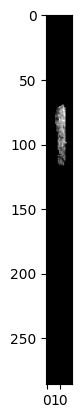

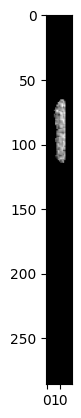

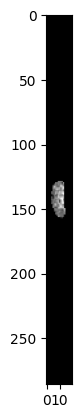

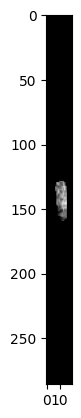

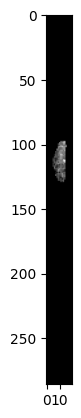

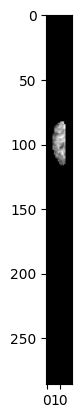

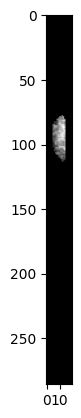

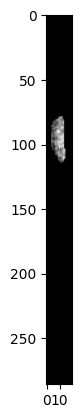

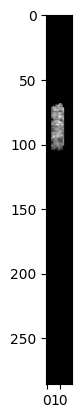

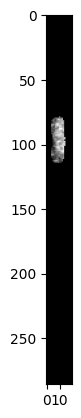

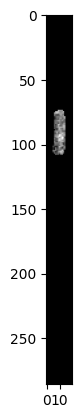

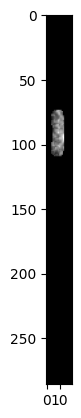

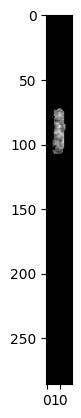

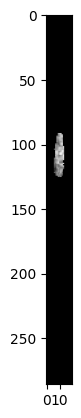

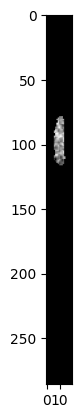

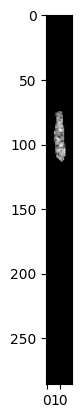

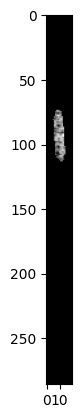

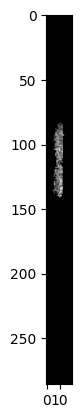

In [71]:
find_cell_intensities2(path_to_fluor_stack, labeled_stack, cell_28_dict, midline=False, start_frame = 28)

In [73]:
cell_28_dict['f2497p0005t0028r02'].fl_area_avgs

[20.845637583892618,
 31.77936962750716,
 23.692307692307693,
 24.47787610619469,
 25.453815261044177,
 25.613475177304963,
 26.325423728813558,
 27.403973509933774,
 27.368115942028986,
 25.88888888888889,
 25.81578947368421,
 22.375757575757575,
 25.392226148409893,
 24.243119266055047,
 22.395437262357415,
 19.868725868725868,
 20.774545454545454,
 17.304225352112677]

In [33]:
cells_dict['f2497p0005t0028r02'].labels

[2, 2, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8]

In [22]:
cells_dict['f2497p0005t0028r02'].times

[28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 48]

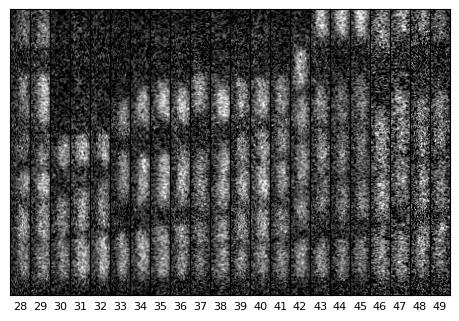

In [24]:
plot_cells.display_stack(path_to_fluor_stack, start=28, end=50)

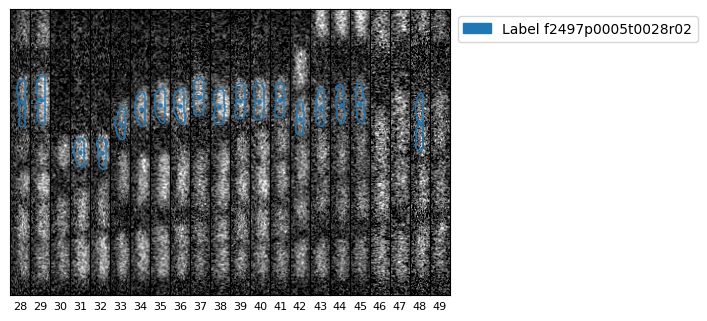

In [49]:
fig = plot_cells.display_cells_from_dict(path_to_fluor_stack, cell_28_dict, start=28, end=50)

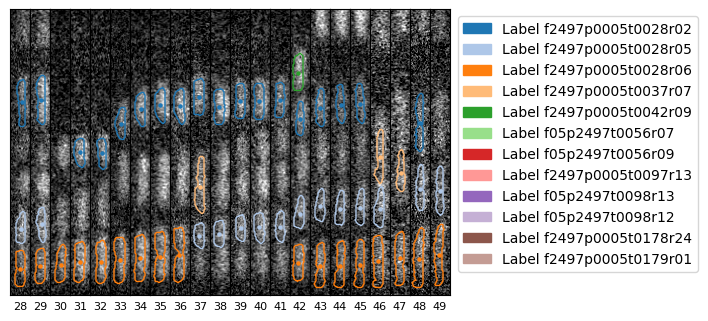

In [26]:
fig = plot_cells.display_cells_from_dict(path_to_fluor_stack, cells_dict, start=28, end=50)

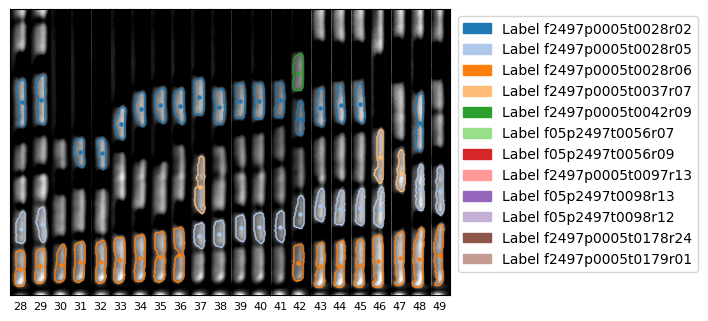

In [27]:
fig = plot_cells.display_cells_from_dict(path_to_phase_stack, cells_dict, start=28, end=50)

In [4]:
def cell_color_dict(cells_df):
    color_dict = {}
    unique_cell_ids = cells_df['cell_id'].unique()
    total_number_labels = len(unique_cell_ids)
    number_of_colors_needed = max(20, total_number_labels)
    # Get a colormap with  distinct colors, for potential cell labels
    cmap = plt.colormaps['tab20'](np.linspace(0, 1, number_of_colors_needed))
    # Create a dictionary mapping integers to hex color codes
    for color_i, cell_id in enumerate(unique_cell_ids):
        color = cmap[color_i, :3]  # Extract RGB values
        color_dict[cell_id] = color
    return color_dict

In [65]:
seg_FOV_dict = {'DUMM_giTG62_Glucose_012925': 
            {'005': ['445', '900', '1128', '1277', '1887',  '2115', '2344', '2421', '2497'],
             '018':['1940', '1483']
            }
           }
# select cells starting at t= 28 for fov 005
lineage_FOV_dict = {'DUMM_giTG62_Glucose_012925': 
            {'005': ['445', '900', '1128', '1277', '1887',  '2115', '2344', '2421', '2497']
            }
           }

445


NameError: name 'cell_color_dict' is not defined

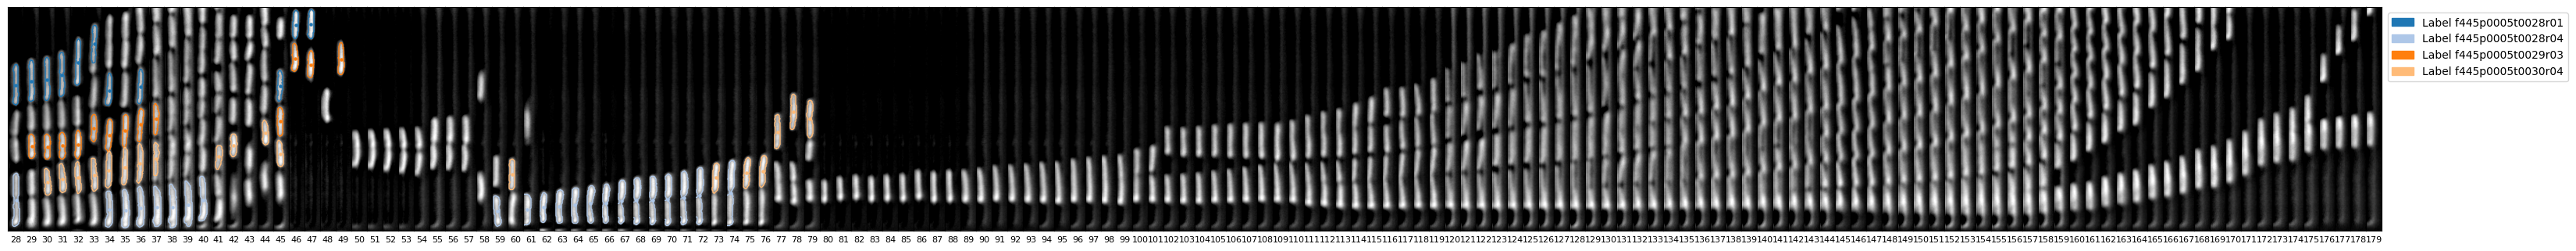

In [69]:
phase_channel = '0'
fluor_channel = '1'
all_cells_pd = pd.DataFrame()
for folder, fov_dict in lineage_FOV_dict.items():
    for fov_id in fov_dict.keys():
        ana_peak_ids = fov_dict[fov_id]
        for peak_id in ana_peak_ids:
            print(peak_id)
            path_to_phase_stack = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/subtracted_FOV_{fov_id}_region_{peak_id}_c_{phase_channel}.tif'
            path_to_fluor_stack = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/subtracted_FOV_{fov_id}_region_{peak_id}_c_{fluor_channel}.tif'
            labeled_stack = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/mm3_segmented_subtracted_FOV_{fov_id}_region_{peak_id}_c_{phase_channel}.tif'
            cells_dict = mm3track.make_lineage_chnl_stack(labeled_stack = labeled_stack, 
                                              fov_id = int(fov_id), 
                                              peak_id = int(peak_id), 
                                              pxl2um = 1,
                                              start_frame = 28)
            mm3track.find_cell_intensities(path_to_fluor_stack, labeled_stack, cells_dict, midline=False, start_frame = 28)
            fig_kymograph = plot_cells.display_cells_from_dict(path_to_phase_stack, cells_dict, start=28, end = 180)
            plot_filename = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/FOV_{fov_id}_region_{peak_id}_kymograph.png'
            plt.savefig(plot_filename, dpi=300)
            cells_pd = mm3track.cells2df(cells_dict, num_time_frames = 5)
            cells_pd['experiment'] = folder
            cells_pd['FOV'] = fov_id
            cells_pd['peak_id'] = peak_id
            if not cells_pd.empty:
                if all_cells_pd.empty:
                    all_cells_pd = cells_pd  
                else:
                    all_cells_pd = pd.concat([all_cells_pd, cells_pd], ignore_index=True)
            else:
                print(f"Warning: cells_pd is empty for folder: {folder}, fov_id: {fov_id}, peak_id: {peak_id}")
            color_dict = cell_color_dict(cells_pd)
            fig_growth, ax = plt.subplots()
            for cell_id, color in color_dict.items():
                cell_df = cells_pd[(cells_pd['cell_id'] == cell_id)]
                ax.plot(cell_df['time_index'], cell_df['lengths_(pxls)'], marker='.', color = color) 
                ax.set_xlabel('time frame')
                ax.set_ylim(0, 50)
                ax.set_ylabel('cell length in pixels')  
            plt.tight_layout()
            plot_filename = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/FOV_{fov_id}_region_{peak_id}_curve.png'
            plt.savefig(plot_filename, dpi=300)
all_cells_filename = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/all_cell_data.csv'
all_cells_pd.to_csv(all_cells_filename)

In [72]:
cells_dict['f445p0005t0028r01'].fl_area_avgs

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [3]:
folder = 'DUMM_giTG62_Glucose_012925'
all_cells_filename = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{folder}/hyperstacked/drift_corrected/rotated/mm_channels/all_cell_data.csv'
all_cells_pd = pd.read_csv(all_cells_filename)

In [4]:
# Evalutate growth curves

In [43]:
from sklearn.metrics import r2_score, mean_squared_error
from scipy.signal import find_peaks
from scipy import stats
import scipy.signal
from scipy.optimize import curve_fit

In [ ]:
cell_df = all_cells_pd[(all_cells_pd['peak_id'] == '1128') & (all_cells_pd['cell_id'] == 'f1128p0005t0036r03')]

In [6]:
def modified_exponential(x, a, b, c):
    return a * np.exp(b*x) + c
def exponential_growth_rate(x, a, b, c): # x is time, a, b and c are fitted parameters
    """Instantaneous growth rate for an exponential function."""
    return a * b * np.exp(b * x) # The growth rate changes over time for an exponential function

In [7]:
def evaluate_fit(y_data, y_fit):
    """Evaluates the goodness of fit using R-squared and MSE."""
    r_squared = r2_score(y_data, y_fit)
    mse = mean_squared_error(y_data, y_fit)
    return r_squared, mse

In [8]:
def fit_cell_growth(df, time_col, length_col, start_time, end_time):
    """Fits exponential functions to cell growth phases.

    Args:
        df: Pandas DataFrame with time and length data.
        time_col: Name of the time column.
        length_col: Name of the length column.
        start_time: Start time of the growth phase.
        end_time: End time of the growth phase.

    Returns:
        popt: Optimized parameters from curve_fit.
        pcov: Covariance matrix from curve_fit.
        y_fit: Fitted y-values.
        r_squared: R-squared value of the fit.
    """

    df_growth = df[(df[time_col] >= start_time) & (df[time_col] <= end_time)]
    x_data = df_growth[time_col].values
    y_data = df_growth[length_col].values

    # Initial guesses (important for exponential fits)
    A_guess = 0.1  # Amplitude
    k_guess = (1/20) 
    b_guess = np.min(y_data)  # Offset

    p0 = [A_guess, k_guess, b_guess]

    lower_bounds = [0, 1/20, 0]  # a, b, c
    upper_bounds = [np.inf, 1/5, np.inf] # a, b, c

    try:
        popt, pcov = curve_fit(modified_exponential, x_data, y_data, p0=p0, 
                               #bounds=(lower_bounds, upper_bounds), 
                               maxfev=5000)
        
        y_fit = modified_exponential(x_data, *popt)
        
        r_squared = r2_score(y_data, y_fit)

        return popt, pcov, y_fit, r_squared
    except RuntimeError as e:
        print(f"Error during curve fitting: {e}")
        return None, None, None, None

In [50]:
#version 2
def detect_exponential_growth(length_array, derivative_threshold=0.1, second_derivative_threshold=0.01, window_size=10, smoothing_window=5, polyorder=2):
    """Detects exponential growth periods in a cell length array with smoothing."""

    # Apply Savitzky-Golay smoothing
    smoothed_length = scipy.signal.savgol_filter(length_array, smoothing_window, polyorder)

    # Calculate derivatives
    derivative = np.gradient(smoothed_length)
    second_derivative = np.gradient(derivative)

    growth_periods = []
    in_growth = False
    start_index = 0

    for i in range(len(smoothed_length)):
        if derivative[i] > derivative_threshold and second_derivative[i] > second_derivative_threshold:
            if not in_growth:
                in_growth = True
                start_index = i
        else:
            if in_growth:
                in_growth = False
                growth_periods.append((start_index, i))
  
    return growth_periods

In [ ]:
# Optional: Curve fitting within detected periods (example)
    exponential_growth_periods_confirmed = []
    def exponential_func(x, a, b):
        return a * np.exp(b * x)

    for start, end in growth_periods:
        try:
            x_data = np.arange(start, end)
            print(x_data)
            y_data = smoothed_length[start:end]
            print(y_data)
            popt, pcov = curve_fit(exponential_func, x_data, y_data, p0=[1, 0.1], maxfev=5000) #p0 are initial guesses
            #check if the b parameter is positive, and if the fit is good.
            if popt[1] > 0:
                exponential_growth_periods_confirmed.append((start,end))
        except RuntimeError:
            print(f"Curve fit failed for period {start}-{end}")

In [58]:
def detect_growth_phases_peaks_smoothed(df, time_col, length_col, prominence=0.5, distance=5, window_size=3):
    """Detects growth phases using peak detection on the smoothed derivative."""
    df_copy = df.copy()
    df_copy = df_copy.reset_index(drop=True)

    df_copy['smoothed_length'] = df_copy[length_col].rolling(window=window_size, center=True).mean()
    df_copy['diff'] = df_copy['smoothed_length'].diff()

    peaks, properties = find_peaks(df_copy['diff'].values, prominence=prominence, distance=distance)
    print(properties)
    growth_phases = []
    last_end_index = -1  # Keep track of the last end index

    for peak_index in peaks:
        if peak_index > last_end_index: #Check if the peak is after the last end
            # Find the start and end of the growth phase around the peak
            peak_time = df_copy[time_col].iloc[peak_index]

            # Search for the start time
            start_index = peak_index
            while start_index > 0 and df_copy['diff'].iloc[start_index] > 0:
                start_index -= 1
            start_time = df_copy[time_col].iloc[start_index]

            # Search for the end time
            end_index = peak_index
            while end_index < len(df_copy) - 1 and df_copy['diff'].iloc[end_index] > 0:
                end_index += 1
            end_time = df_copy[time_col].iloc[end_index]

            growth_phases.append((start_time, end_time))
            last_end_index = end_index #Update the last end index

    return growth_phases

In [59]:
def plot_growth_analysis(cell_df, cell_id, time_col, length_col, prominence=0.3, distance=3, window_size=3):
    """Analyzes and plots cell growth data, returning the DataFrame with fit data.

    Args:
        cell_df (pd.DataFrame): DataFrame containing cell data.
        time_col (str): Name of the time column.
        length_col (str): Name of the length column.
        prominence (float): Prominence parameter for peak detection.
        distance (int): Distance parameter for peak detection.
        window_size (int): Window size for smoothing.

    Returns:
        pd.DataFrame: The input DataFrame with added 'y_fit' and 'r_squared' columns.
                           'y_fit' will be NaN outside of fitted regions.
                           'r_squared' will be NaN outside of fitted regions.
    """


    growth_phases = detect_growth_phases_peaks_smoothed(cell_df, time_col, length_col, prominence, distance, window_size)

    # Initialize new columns with NaN
    cell_df['y_fit'] = np.nan
    cell_df['residuals'] = np.nan
    cell_df['r_squared'] = np.nan
    cell_df['growth_phase'] = None

    plt.figure(figsize=(10, 6))

    # Plot entire cell data first, behind everything else
    plt.plot(cell_df[time_col], cell_df[length_col], 'o', color='grey', alpha=0.5, label=f'Entire cell data for {cell_id}')

    if growth_phases:
        for i, (start, end) in enumerate(growth_phases):
            print(f"Fitting growth phase {i+1} from {start} to {end}")

            cell_growth_data = cell_df[(cell_df[time_col] >= start) & (cell_df[time_col] <= end)]
            
            if len(cell_growth_data) < 3: #Check for phases with less than 3 points
                print(f"Skipping phase {i+1} ({start}-{end}) due to insufficient data points.")
                continue #Skip to the next iteration of the loop

            popt, pcov, y_fit, r_squared = fit_cell_growth(cell_growth_data, time_col, length_col, start, end)


            if popt is not None:
                print(f"  Fit parameters: A={popt[0]:.2f}, k={popt[1]:.4f}, b={popt[2]:.2f}")
                print(f"  R-squared: {r_squared:.4f}")
                residuals = cell_growth_data[length_col].values - y_fit
                 
                r_squared_threshold = 0.3
                if r_squared < r_squared_threshold:
                    print(f"Skipping phase {i+1} ({start}-{end}) due to poor fit (R-squared = {r_squared:.4f} < {r_squared_threshold}).")
                    continue 

                # Store y_fit and r_squared in the original DataFrame
                cell_df.loc[(cell_df[time_col] >= start) & (cell_df[time_col] <= end), 'y_fit'] = y_fit
                cell_df.loc[(cell_df[time_col] >= start) & (cell_df[time_col] <= end), 'residuals'] = residuals
                cell_df.loc[(cell_df[time_col] >= start) & (cell_df[time_col] <= end), 'r_squared'] = r_squared
                cell_df.loc[(cell_df[time_col] >= start) & (cell_df[time_col] <= end), 'growth_phase'] = f'growth phase {i+1} ({start}-{end})'


                plt.plot(cell_growth_data[time_col], cell_growth_data[length_col], 'o', label=f'Growth phase {i+1} ({start}-{end})')
                plt.plot(cell_growth_data[time_col], y_fit, '-', label=f'Fit {i+1} ({start}-{end})')
            else:
                print(f"  Fit failed for phase {i+1} ({start}-{end})")

        plt.title("Growth fits (all phases)")

    else:
        print("No growth phases detected.")
        plt.title("Cell data (no growth phases detected)")

    plt.xlabel('Time frame index')
    plt.ylabel('Cell length (pxls)')
    plt.legend()
    plt.show()

    return cell_df  # Return the modified DataFrame

# Do linear transform here before the fit or before finding phases of growth? Before for better peak detection. Revised function below


def plot_growth_analysis(cell_df, cell_id, time_col, length_col, prominence=0.3, distance=3, window_size=3):
    """Analyzes and plots cell growth data, returning the DataFrame with fit data.

    Args:
        cell_df (pd.DataFrame): DataFrame containing cell data.
        time_col (str): Name of the time column.
        length_col (str): Name of the length column.
        prominence (float): Prominence parameter for peak detection.
        distance (int): Distance parameter for peak detection.
        window_size (int): Window size for smoothing.

    Returns:
        pd.DataFrame: The input DataFrame with added 'y_fit' and 'r_squared' columns.
                           'y_fit' will be NaN outside of fitted regions.
                           'r_squared' will be NaN outside of fitted regions.
    """
    cell_df_copy = cell_df.copy()
    # Handle potential zero or negative values
    min_val = cell_df_copy[length_col].min()
    if min_val <= 0:
        cell_df_copy[length_col] = cell_df_copy[length_col] + abs(min_val) + 1

    # Apply the linear transformation (logarithm)
    cell_df_copy['log_length'] = np.log(cell_df_copy[length_col])


    growth_phases = detect_growth_phases_peaks_smoothed(cell_df_copy, time_col, 'log_length', prominence, distance, window_size)

    # Initialize new columns with NaN
    cell_df['y_fit'] = np.nan
    cell_df['residuals'] = np.nan
    cell_df['r_squared'] = np.nan
    cell_df['growth_phase'] = None

    plt.figure(figsize=(10, 6))

    # Plot entire cell data first, behind everything else
    plt.plot(cell_df[time_col], cell_df[length_col], 'o', color='grey', alpha=0.5, label=f'Entire cell data for {cell_id}')

    if growth_phases:
        for i, (start, end) in enumerate(growth_phases):
            print(f"Fitting growth phase {i+1} from {start} to {end}")

            cell_growth_data = cell_df[(cell_df[time_col] >= start) & (cell_df[time_col] <= end)]
            cell_growth_data_log = cell_df_copy[(cell_df_copy[time_col] >= start) & (cell_df_copy[time_col] <= end)]
            
            if len(cell_growth_data) < 3: #Check for phases with less than 3 points
                print(f"Skipping phase {i+1} ({start}-{end}) due to insufficient data points.")
                continue #Skip to the next iteration of the loop

            # Fit a linear model to the log-transformed data
            slope, intercept, r_value, p_value, std_err = stats.linregress(cell_growth_data_log[time_col], cell_growth_data_log['log_length'])
            y_fit_log = slope * cell_growth_data_log[time_col] + intercept
            y_fit = np.exp(y_fit_log)  # Transform back to original scale
            r_squared = r_value**2
            residuals = cell_growth_data[length_col].values - y_fit

            # Outlier Detection (IQR method)
            q1 = np.percentile(residuals, 25)
            q3 = np.percentile(residuals, 75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr

            outlier_indices = np.where((residuals < lower_bound) | (residuals > upper_bound))[0]

            if len(outlier_indices) > 0:
                print(f"  Outliers detected in phase {i+1}: {outlier_indices}")

                # Remove outliers from the data
                cell_growth_data_no_outliers = cell_growth_data.iloc[
                    [j for j in range(len(cell_growth_data)) if j not in outlier_indices]
                ]
                cell_growth_data_log_no_outliers = cell_growth_data_log.iloc[
                    [j for j in range(len(cell_growth_data_log)) if j not in outlier_indices]
                ]

                # Refit the model without outliers
                if len(cell_growth_data_no_outliers) >= 2: #must have at least two points to perform linear regression.
                    slope, intercept, r_value, p_value, std_err = stats.linregress(
                        cell_growth_data_log_no_outliers[time_col], cell_growth_data_log_no_outliers['log_length']
                    )
                    y_fit_log = slope * cell_growth_data_log_no_outliers[time_col] + intercept
                    y_fit = np.exp(y_fit_log)
                    r_squared = r_value**2
                    residuals = cell_growth_data_no_outliers[length_col].values - y_fit
                    cell_growth_data = cell_growth_data_no_outliers #replace the old growth data with the outlier free data.
                else:
                    print(f"Skipping phase {i+1} ({start}-{end}) due to insufficient data points after outlier removal.")
                    continue

            if slope is not None:
                print(f"  Fit parameters: slope={slope:.4f}, intercept={intercept:.2f}")
                print(f"  R-squared: {r_squared:.4f}")
                
                r_squared_threshold = 0.3
                if r_squared < r_squared_threshold:
                    print(f"Skipping phase {i+1} ({start}-{end}) due to poor fit (R-squared = {r_squared:.4f} < {r_squared_threshold}).")
                    continue

                # Store y_fit and r_squared in the original DataFrame
                cell_df.loc[(cell_df[time_col] >= start) & (cell_df[time_col] <= end), 'y_fit'] = y_fit
                cell_df.loc[(cell_df[time_col] >= start) & (cell_df[time_col] <= end), 'residuals'] = residuals
                cell_df.loc[(cell_df[time_col] >= start) & (cell_df[time_col] <= end), 'r_squared'] = r_squared
                cell_df.loc[(cell_df[time_col] >= start) & (cell_df[time_col] <= end), 'growth_phase'] = f'growth phase {i+1} ({start}-{end})'

                plt.plot(cell_growth_data[time_col], cell_growth_data[length_col], 'o', label=f'Growth phase {i+1} ({start}-{end})')
                plt.plot(cell_growth_data[time_col], y_fit, '-', label=f'Fit {i+1} ({start}-{end})')
            else:
                print(f"  Fit failed for phase {i+1} ({start}-{end})")

        plt.title(f"Growth fits (all phases) for cell {cell_id}")

    else:
        print("No growth phases detected.")
        plt.title(f"Cell data (no growth phases detected) for cell {cell_id}")

    plt.xlabel(time_col)
    plt.ylabel(length_col + ' (pxls)')
    plt.legend()
    plt.show()

    return cell_df  # Return the modified DataFrame

# Trying a different approach to detect periods of cell growth based on derivatives

In [ ]:
detect_exponential_growth(length_array, derivative_threshold=0.1, second_derivative_threshold=0.01, window_size=10, smoothing_window=5, polyorder=2)

def plot_growth_analysis(cell_df, cell_id, time_col, length_col):
    """Analyzes and plots cell growth data, returning the DataFrame with fit data.

    Args:
        cell_df (pd.DataFrame): DataFrame containing cell data.
        time_col (str): Name of the time column.
        length_col (str): Name of the length column.
        prominence (float): Prominence parameter for peak detection.
        distance (int): Distance parameter for peak detection.
        window_size (int): Window size for smoothing.

    Returns:
        pd.DataFrame: The input DataFrame with added 'y_fit' and 'r_squared' columns.
                           'y_fit' will be NaN outside of fitted regions.
                           'r_squared' will be NaN outside of fitted regions.
    """

    growth_phases = detect_exponential_growth(cell_df[length_col], derivative_threshold=0.1, second_derivative_threshold=0.01, window_size=10, smoothing_window=5, polyorder=2)

    # Initialize new columns with NaN
    cell_df['y_fit'] = np.nan
    cell_df['residuals'] = np.nan
    cell_df['r_squared'] = np.nan
    cell_df['growth_phase'] = None

    plt.figure(figsize=(10, 6))

    # Plot entire cell data first, behind everything else
    plt.plot(cell_df[time_col], cell_df[length_col], 'o', color='grey', alpha=0.5, label=f'Entire cell data for {cell_id}')

    if growth_phases:
        print(growth_phases)
        for i, (start, end) in enumerate(growth_phases):
            print(f"Fitting growth phase {i+1} from {start} to {end}")

            cell_growth_data = cell_df[(cell_df[time_col] >= start) & (cell_df[time_col] <= end)]
            
            if len(cell_growth_data) < 3: #Check for phases with less than 3 points
                print(f"Skipping phase {i+1} ({start}-{end}) due to insufficient data points.")
                continue #Skip to the next iteration of the loop
            print(f"Start: {start}, End: {end}")
            
            popt, pcov, y_fit, r_squared = fit_cell_growth(cell_growth_data, time_col, length_col, start, end)


            if popt is not None:
                print(f"  Fit parameters: A={popt[0]:.2f}, k={popt[1]:.4f}, b={popt[2]:.2f}")
                print(f"  R-squared: {r_squared:.4f}")
                residuals = cell_growth_data[length_col].values - y_fit
                 
                r_squared_threshold = 0.3
                if r_squared < r_squared_threshold:
                    print(f"Skipping phase {i+1} ({start}-{end}) due to poor fit (R-squared = {r_squared:.4f} < {r_squared_threshold}).")
                    continue 

                # Store y_fit and r_squared in the original DataFrame
                cell_df.loc[(cell_df[time_col] >= start) & (cell_df[time_col] <= end), 'y_fit'] = y_fit
                cell_df.loc[(cell_df[time_col] >= start) & (cell_df[time_col] <= end), 'residuals'] = residuals
                cell_df.loc[(cell_df[time_col] >= start) & (cell_df[time_col] <= end), 'r_squared'] = r_squared
                cell_df.loc[(cell_df[time_col] >= start) & (cell_df[time_col] <= end), 'growth_phase'] = f'growth phase {i+1} ({start}-{end})'


                plt.plot(cell_growth_data[time_col], cell_growth_data[length_col], 'o', label=f'Growth phase {i+1} ({start}-{end})')
                plt.plot(cell_growth_data[time_col], y_fit, '-', label=f'Fit {i+1} ({start}-{end})')
            else:
                print(f"  Fit failed for phase {i+1} ({start}-{end})")

        plt.title("Growth fits (all phases)")

    else:
        print("No growth phases detected.")
        plt.title("Cell data (no growth phases detected)")

    plt.xlabel('Time frame index')
    plt.ylabel('Cell length (pxls)')
    plt.legend()
    plt.show()

    return cell_df  # Return the modified DataFrame

In [16]:
updated_cell_df = plot_growth_analysis(cell_df.copy(), 'time_index', 'lengths_(pxls)', prominence=0.3, distance=3, window_size=3)

TypeError: plot_growth_analysis() missing 1 required positional argument: 'length_col'

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler

In [ ]:
def cluster_growth_traces(cell_df, cell_id_col, growth_phase_col, time_col, length_col, method='ward', metric='euclidean'):
    """Performs hierarchical clustering on cell growth traces.

    Args:
        cell_df (pd.DataFrame): DataFrame with cell IDs, time, and length data.
        time_col (str): Name of the time column.
        length_col (str): Name of the length column.
        method (str): Linkage method for hierarchical clustering (e.g., 'ward', 'average', 'complete').
        metric (str): Distance metric (e.g., 'euclidean', 'correlation').

    Returns:
        tuple: A tuple containing the linkage matrix and the figure/axes of the dendrogram.
               Returns None if there's an issue with the data.
    """

    try:
        # 1. Data Preparation: Reshape and Normalize
        # Pivot the table to have cell IDs as rows and time points as columns
        growth_matrix = cell_df.pivot(index=[cell_id_col, growth_phase_col] , columns=time_col, values=length_col)

        # Handle NaNs (important!)
        growth_matrix = growth_matrix.fillna(growth_matrix.mean()) # or other strategies


        # Normalize (important!) - crucial for meaningful distances
        scaler = StandardScaler()
        normalized_growth_matrix = scaler.fit_transform(growth_matrix)
        cell_ids = growth_matrix.index 

        # 2. Hierarchical Clustering
        linked = linkage(normalized_growth_matrix, method=method, metric=metric)

        # 3. Dendrogram Plotting
        plt.figure(figsize=(10, 7))
        dendrogram_result = dendrogram(linked, orientation='top', labels=growth_matrix.index,  # Use cell IDs as labels
                                      distance_sort='descending', show_leaf_counts=True) #Show leaf counts

        plt.title("Hierarchical Clustering Dendrogram")
        plt.xlabel("Cell ID")
        plt.ylabel("Distance")

        return linked, cell_ids, plt.gcf(), plt.gca() # Return linkage matrix and dendrogram figure

    except Exception as e:
        print(f"Error during clustering: {e}")
        return None

In [ ]:
all_cells_clustered['cluster'].unique()

# First establish the growth periods then cluster purely on detected growth periods?

In [11]:
all_cells_pd['cell_id'].unique()

array(['f445p0005t0028r01', 'f445p0005t0028r04', 'f445p0005t0029r03',
       'f445p0005t0030r04', 'f900p0005t0028r01', 'f900p0005t0028r02',
       'f900p0005t0062r02', 'f900p0005t0072r04', 'f05p1128t0052r04',
       'f05p1128t0052r05', 'f05p1128t0058r05', 'f05p1128t0058r07',
       'f05p1128t0060r09', 'f05p1128t0074r09', 'f1128p0005t0028r01',
       'f1128p0005t0028r02', 'f1128p0005t0036r03', 'f1128p0005t0037r05',
       'f1277p0005t0028r01', 'f1277p0005t0028r02', 'f1277p0005t0028r04',
       'f1277p0005t0028r05', 'f1277p0005t0136r13', 'f05p1887t0058r08',
       'f05p1887t0058r10', 'f05p1887t0060r10', 'f05p1887t0060r11',
       'f05p1887t0063r11', 'f05p1887t0063r12', 'f05p1887t0076r11',
       'f05p1887t0080r11', 'f05p1887t0080r13', 'f05p1887t0095r16',
       'f05p1887t0102r16', 'f1887p0005t0028r02', 'f1887p0005t0028r03',
       'f1887p0005t0030r04', 'f1887p0005t0031r05', 'f05p2115t0035r02',
       'f05p2115t0035r03', 'f05p2115t0048r09', 'f05p2115t0070r10',
       'f2115p0005t0028r03',

{'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64)}
No growth phases detected.


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

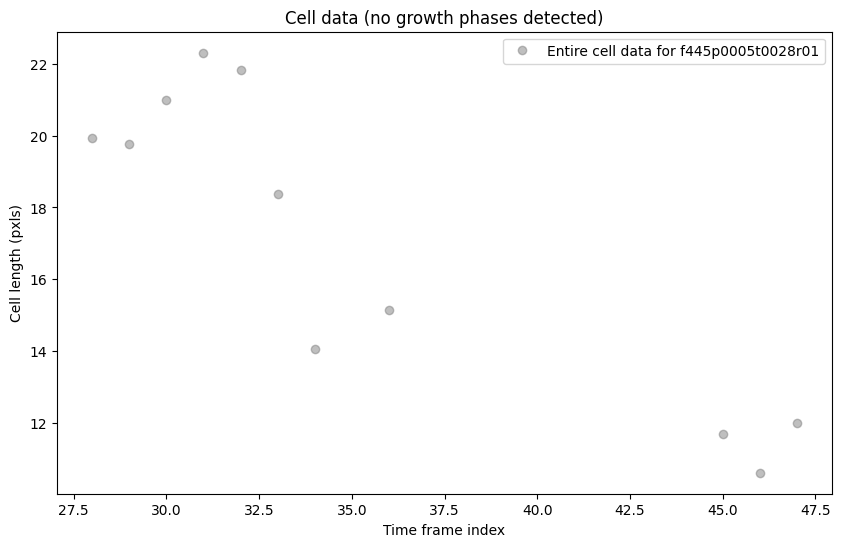

{'prominences': array([4.65454534, 1.49871091, 0.54259639]), 'left_bases': array([ 2,  9, 14]), 'right_bases': array([ 9, 18, 18])}
Fitting growth phase 1 from 36 to 40
  Fit parameters: A=0.00, k=2.1041, b=18.01
  R-squared: 0.9750
Fitting growth phase 2 from 61 to 74
  Fit parameters: A=0.61, k=0.0553, b=-4.16
  R-squared: 0.9569


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

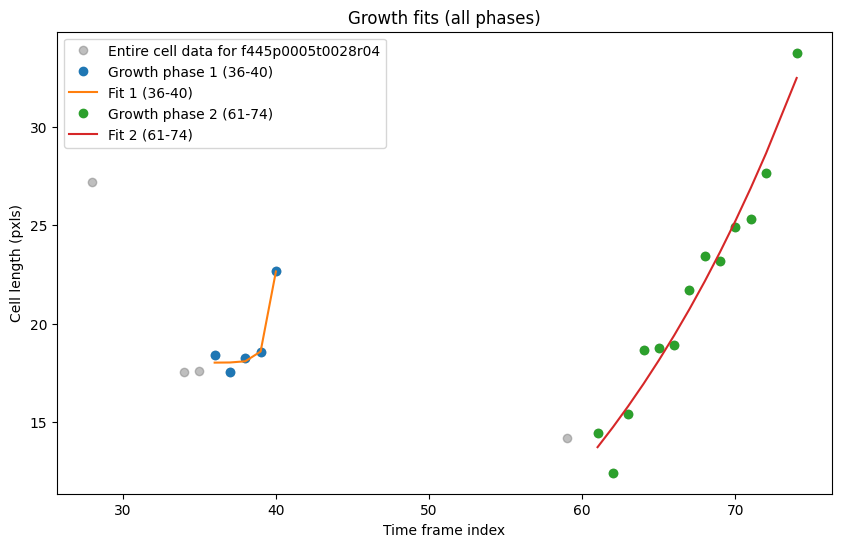

{'prominences': array([1.64604404]), 'left_bases': array([2]), 'right_bases': array([9])}
Fitting growth phase 1 from 32 to 36
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 1 (32-36)


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

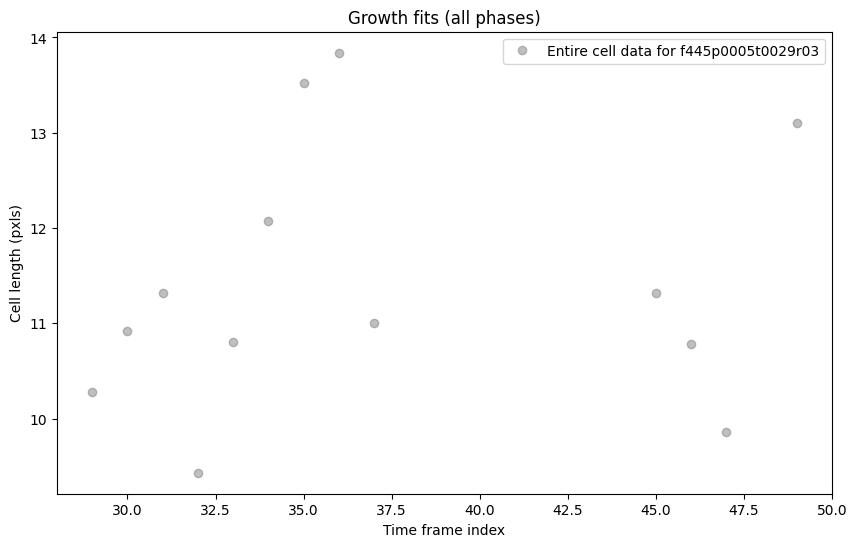

{'prominences': array([0.39199988, 0.41374574, 1.96551983, 0.47225183]), 'left_bases': array([ 3,  7,  7, 14]), 'right_bases': array([ 7,  9, 14, 16])}
Fitting growth phase 1 from 31 to 37
  Fit parameters: A=8948.89, k=0.0001, b=-8955.28
  R-squared: 0.6967
Fitting growth phase 2 from 41 to 41
Skipping phase 2 (41-41) due to insufficient data points.
Fitting growth phase 3 from 44 to 75
  Fit parameters: A=9761.09, k=0.0000, b=-9755.89
  R-squared: 0.5122
Fitting growth phase 4 from 75 to 79
  Fit parameters: A=0.00, k=0.9594, b=12.80
  R-squared: 0.8797


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

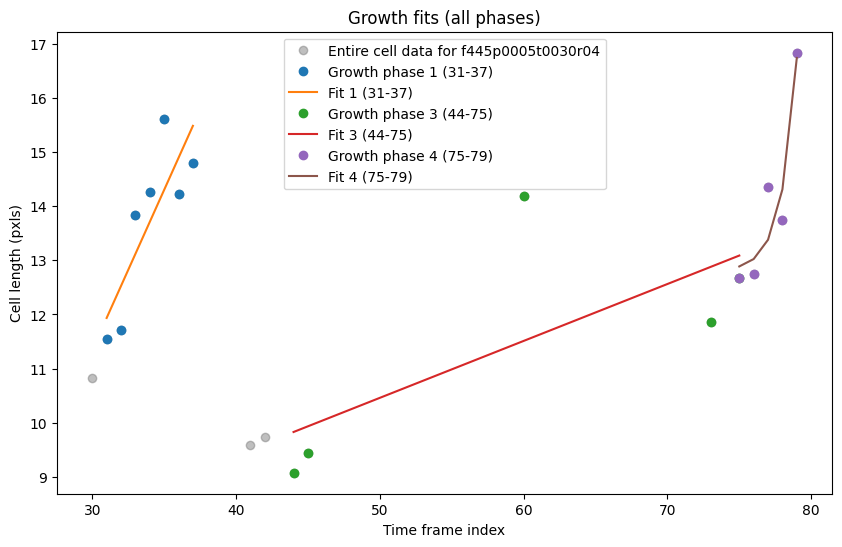

{'prominences': array([1.76052869]), 'left_bases': array([3]), 'right_bases': array([10])}
Fitting growth phase 1 from 31 to 39
  Fit parameters: A=2.39, k=0.0696, b=-9.94
  R-squared: 0.9141


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

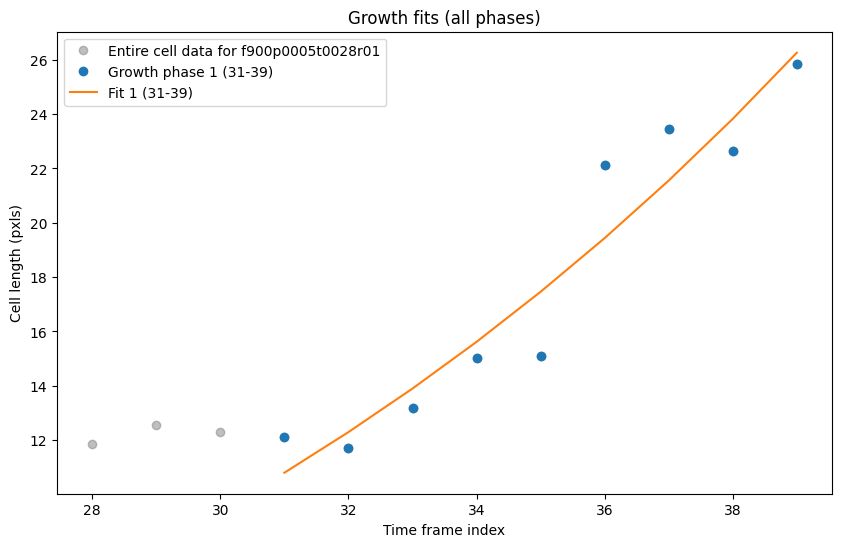

{'prominences': array([0.87624096, 2.0599949 , 0.27380582, 0.81803308, 3.84218152]), 'left_bases': array([ 3, 12, 17, 17, 25]), 'right_bases': array([12, 25, 20, 25, 32])}
Fitting growth phase 1 from 29 to 40
  Fit parameters: A=68.63, k=0.0063, b=-72.05
  R-squared: 0.8820
Fitting growth phase 2 from 40 to 52
  Fit parameters: A=16655.40, k=0.0000, b=-16665.03
  R-squared: 0.8487
Fitting growth phase 3 from 66 to 83
  Fit parameters: A=29824.50, k=0.0000, b=-29840.78
  R-squared: 0.3540


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

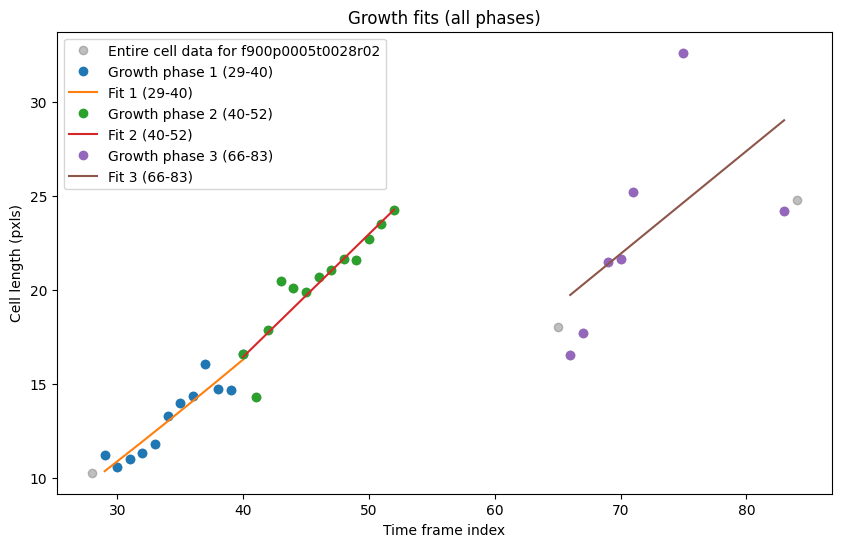

{'prominences': array([0.70783148]), 'left_bases': array([5]), 'right_bases': array([9])}
Fitting growth phase 1 from 63 to 72
  Fit parameters: A=3.96, k=0.0318, b=-12.42
  R-squared: 0.9343


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

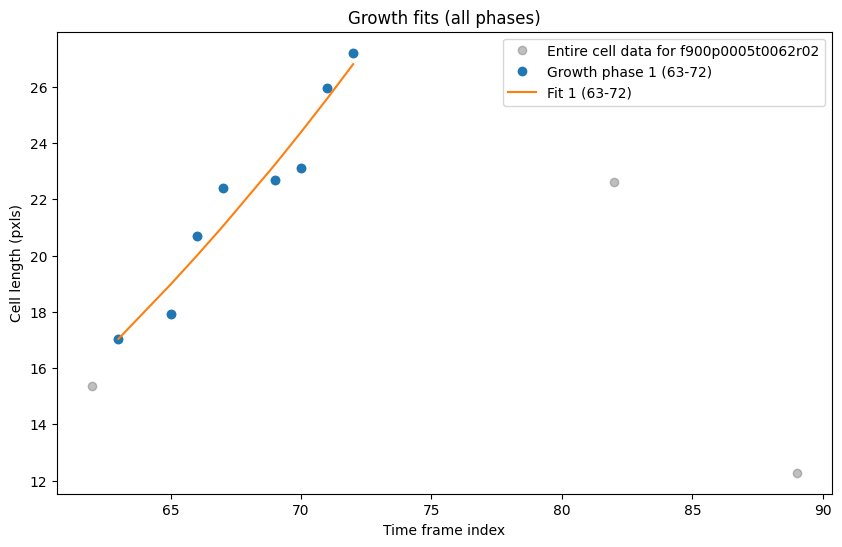

{'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64)}
No growth phases detected.


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

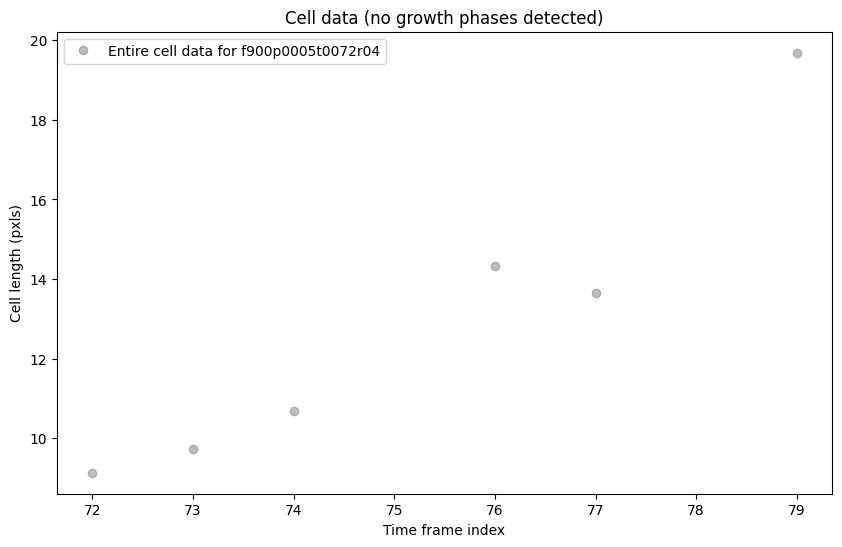

{'prominences': array([0.71875   , 1.98165045]), 'left_bases': array([2, 7]), 'right_bases': array([7, 9])}
Fitting growth phase 1 from 53 to 59


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

  Fit parameters: A=0.02, k=0.1147, b=5.30
  R-squared: 0.9899
Fitting growth phase 2 from 69 to 71
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 2 (69-71)


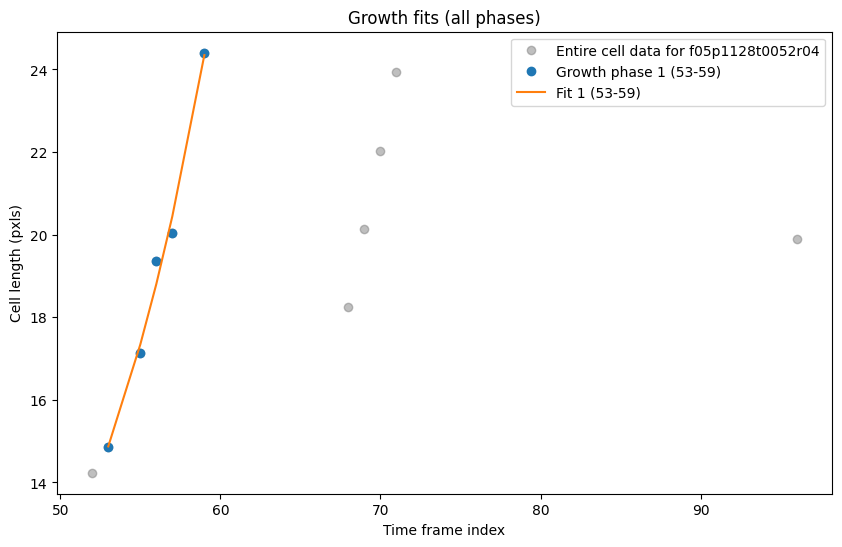

{'prominences': array([2.89664084]), 'left_bases': array([4]), 'right_bases': array([7])}
Fitting growth phase 1 from 53 to 59
  Fit parameters: A=0.00, k=1.0397, b=12.53
  R-squared: 0.9631


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

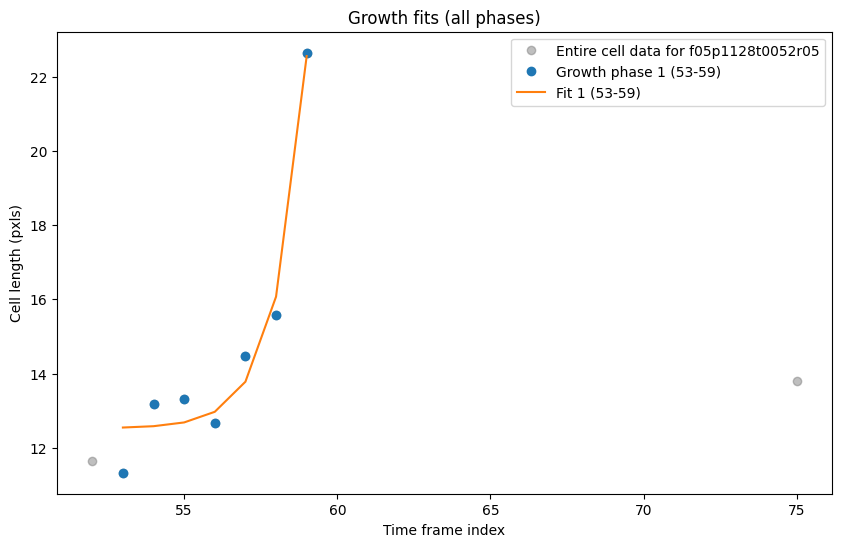

{'prominences': array([2.72833293]), 'left_bases': array([2]), 'right_bases': array([7])}
Fitting growth phase 1 from 65 to 83
  Fit parameters: A=12758.81, k=0.0000, b=-12758.85
  R-squared: 0.3139


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

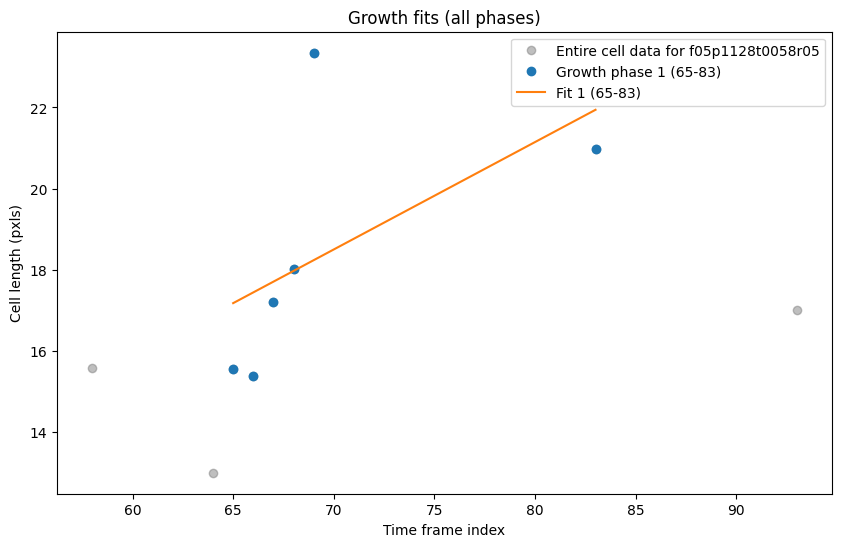

{'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64)}
No growth phases detected.


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

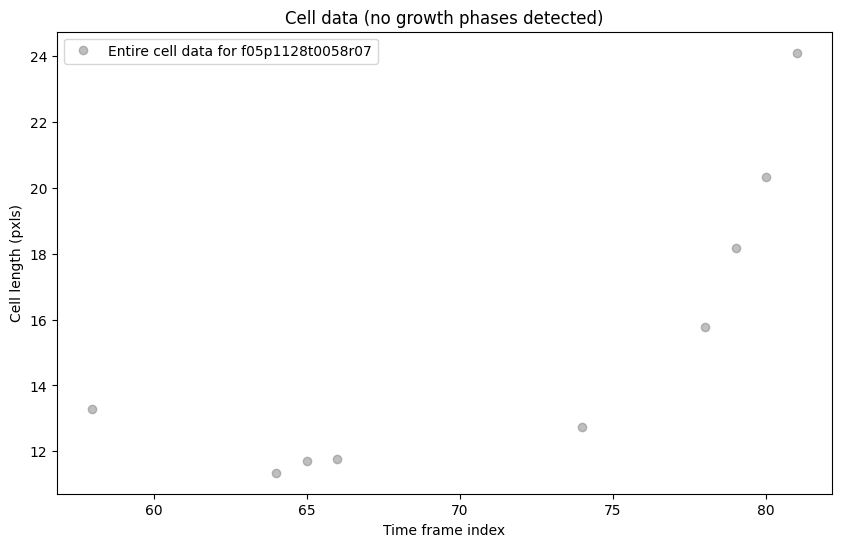

{'prominences': array([1.05544337]), 'left_bases': array([3]), 'right_bases': array([9])}
Fitting growth phase 1 from 61 to 82
  Fit parameters: A=16650.43, k=0.0000, b=-16655.69
  R-squared: 0.7338


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

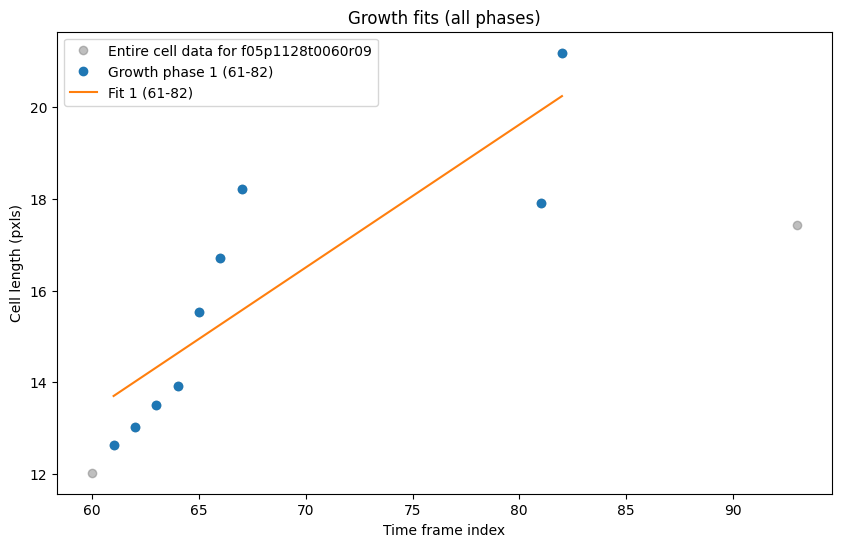

{'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64)}
No growth phases detected.


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

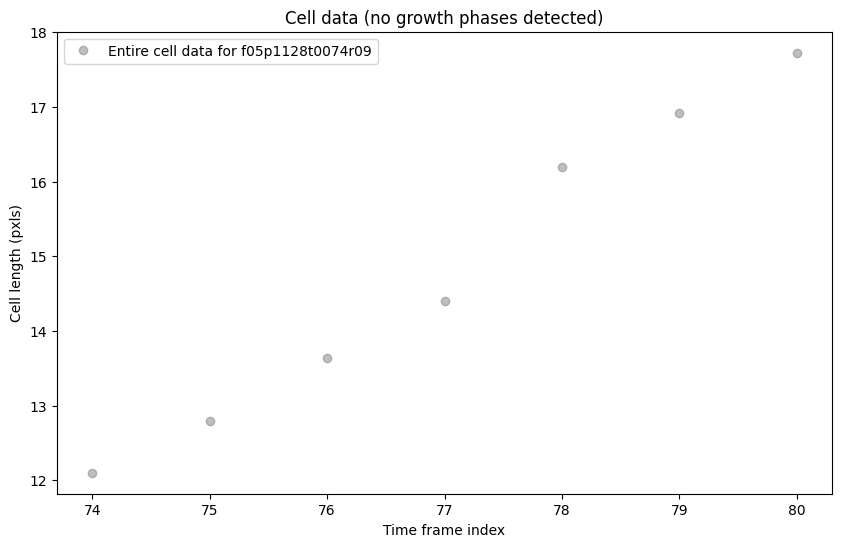

{'prominences': array([0.1171875 , 3.41983177, 0.57552083]), 'left_bases': array([ 5,  5, 15]), 'right_bases': array([ 9, 19, 19])}
Fitting growth phase 1 from 38 to 50
  Fit parameters: A=4.24, k=0.0385, b=-7.92
  R-squared: 0.9608


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

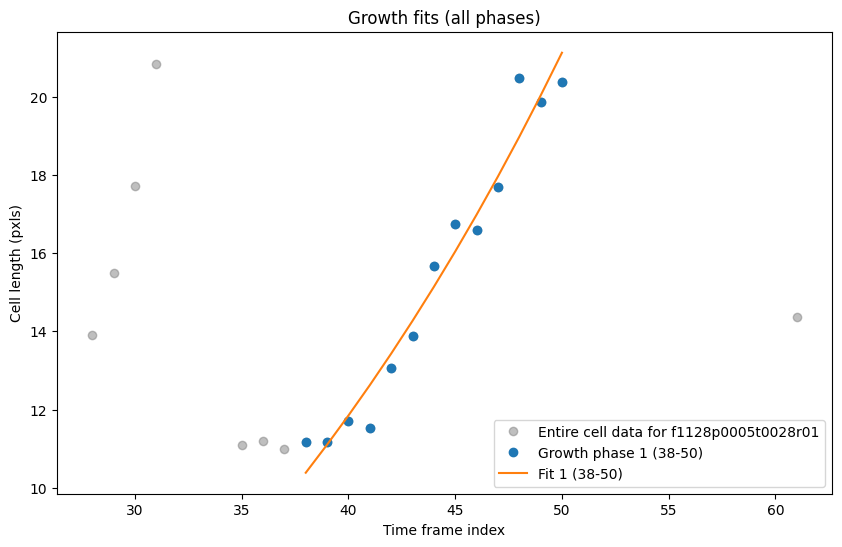

{'prominences': array([2.04947917, 1.75101293]), 'left_bases': array([3, 8]), 'right_bases': array([ 8, 14])}
Fitting growth phase 1 from 29 to 43
  Fit parameters: A=0.24, k=-1.6875, b=17.68
  R-squared: 0.0000
Skipping phase 1 (29-43) due to poor fit (R-squared = 0.0000 < 0.3).
Fitting growth phase 2 from 44 to 98
  Fit parameters: A=9623.08, k=0.0000, b=-9605.18
  R-squared: 0.2256
Skipping phase 2 (44-98) due to poor fit (R-squared = 0.2256 < 0.3).


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

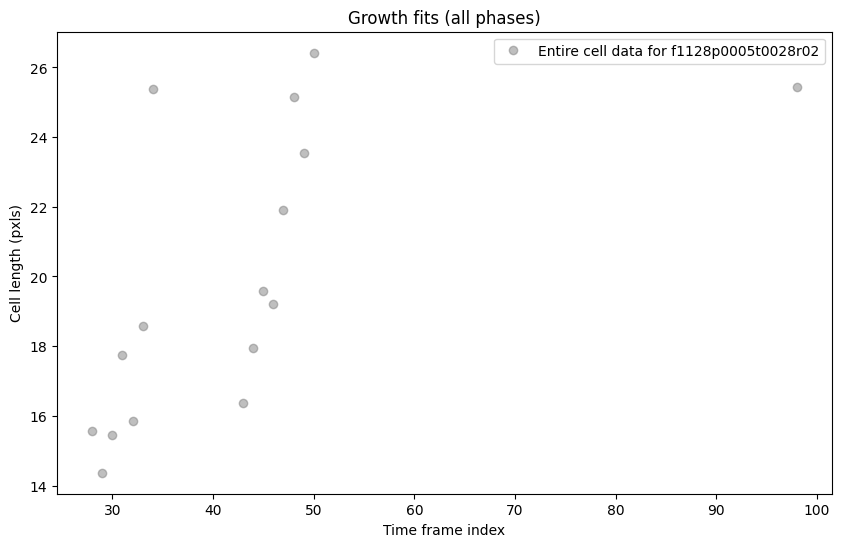

{'prominences': array([0.6080966 , 1.87868919, 0.24056077]), 'left_bases': array([ 2,  2, 14]), 'right_bases': array([ 8, 14, 18])}
Fitting growth phase 1 from 38 to 48
  Fit parameters: A=0.00, k=0.1774, b=9.62
  R-squared: 0.9683
Fitting growth phase 2 from 55 to 77
  Fit parameters: A=8271.71, k=0.0000, b=-8268.00
  R-squared: 0.8883


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

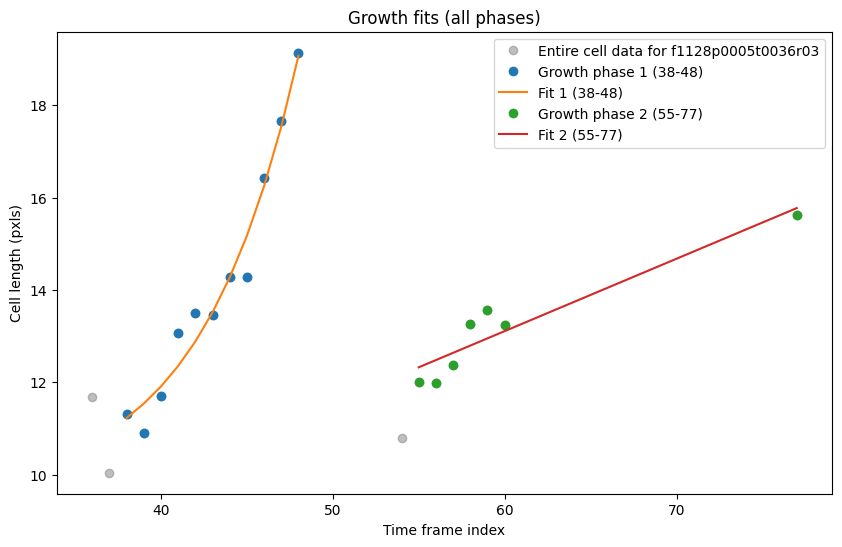

{'prominences': array([1.03199734, 3.06620398]), 'left_bases': array([2, 8]), 'right_bases': array([ 8, 11])}
Fitting growth phase 1 from 38 to 43
  Fit parameters: A=0.00, k=0.3770, b=13.34
  R-squared: 0.9428
Fitting growth phase 2 from 59 to 94
  Fit parameters: A=16632.23, k=0.0000, b=-16627.54
  R-squared: 0.2868
Skipping phase 2 (59-94) due to poor fit (R-squared = 0.2868 < 0.3).


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

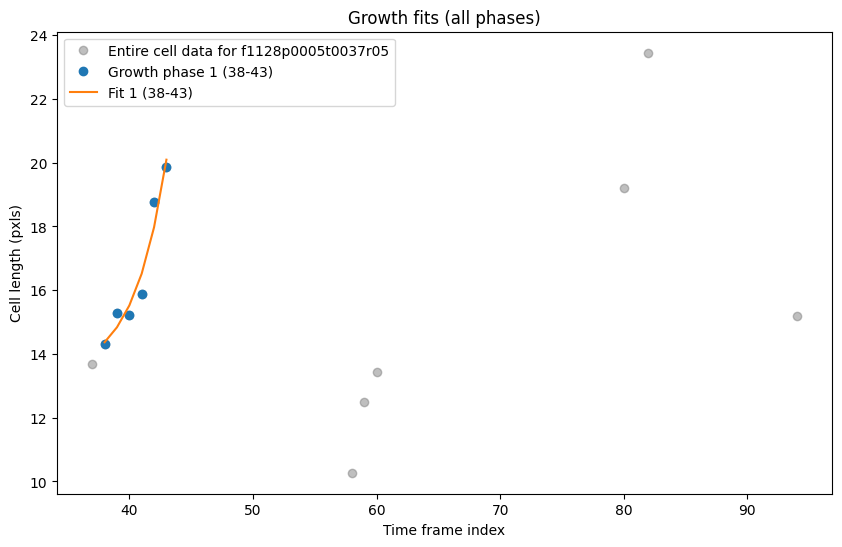

{'prominences': array([4.33580263, 0.34704641]), 'left_bases': array([ 2, 10]), 'right_bases': array([10, 12])}
Fitting growth phase 1 from 31 to 36
  Fit parameters: A=0.00, k=0.2958, b=9.27
  R-squared: 0.9939
Fitting growth phase 2 from 42 to 48
  Fit parameters: A=0.00, k=0.6952, b=10.95
  R-squared: 0.8975


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

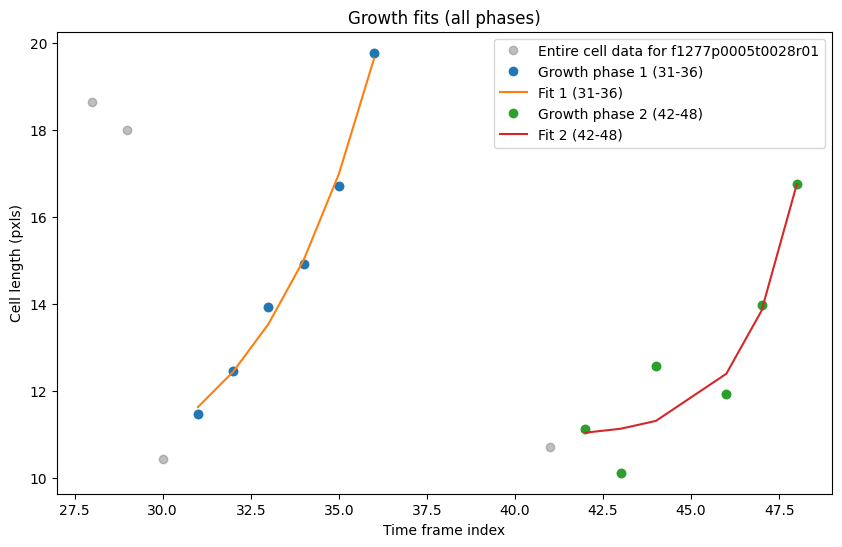

{'prominences': array([1.04175687]), 'left_bases': array([4]), 'right_bases': array([9])}
Fitting growth phase 1 from 37 to 45
  Fit parameters: A=0.03, k=0.1378, b=4.55
  R-squared: 0.9390


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

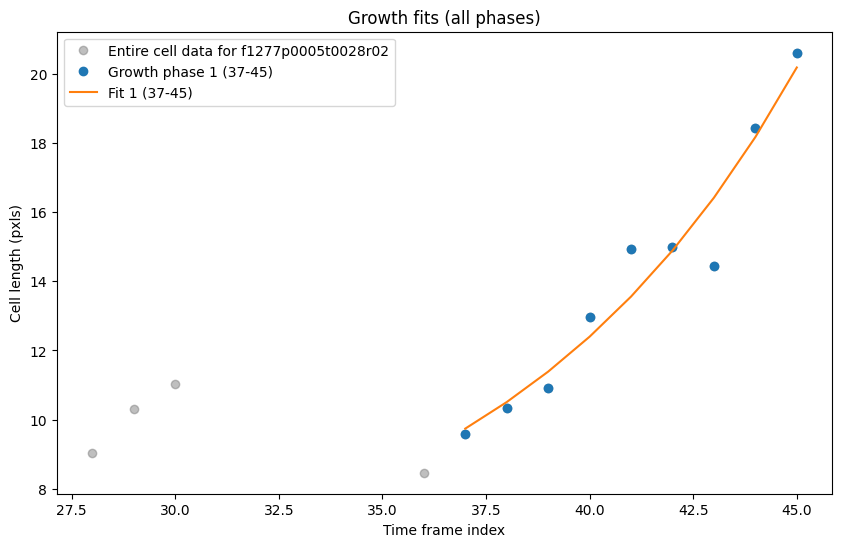

{'prominences': array([2.20238598, 2.75608169, 2.78789885, 4.34002514, 0.76406391,
       7.67083827, 1.96633312, 1.40638761, 0.81678958, 4.10775781]), 'left_bases': array([ 3, 10, 10, 10, 27, 10, 34, 39, 39, 34]), 'right_bases': array([10, 15, 23, 27, 29, 34, 39, 47, 49, 54])}
Fitting growth phase 1 from 31 to 36
  Fit parameters: A=1.68, k=0.0758, b=-6.01
  R-squared: 0.9498


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

Fitting growth phase 2 from 42 to 46
  Fit parameters: A=8.72, k=0.0331, b=-24.65
  R-squared: 0.8553
Fitting growth phase 3 from 66 to 84
  Fit parameters: A=22.24, k=-0.0001, b=-8.72
  R-squared: 0.0000
Skipping phase 3 (66-84) due to poor fit (R-squared = 0.0000 < 0.3).
Fitting growth phase 4 from 88 to 92
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 4 (88-92)
Fitting growth phase 5 from 95 to 97
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 5 (95-97)
Fitting growth phase 6 from 97 to 125
  Fit parameters: A=10403.74, k=0.0000, b=-10403.67
  R-squared: 0.1138
Skipping phase 6 (97-125) due to poor fit (R-squared = 0.1138 < 0.3).
Fitting growth phase 7 from 127 to 129
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 7 (12

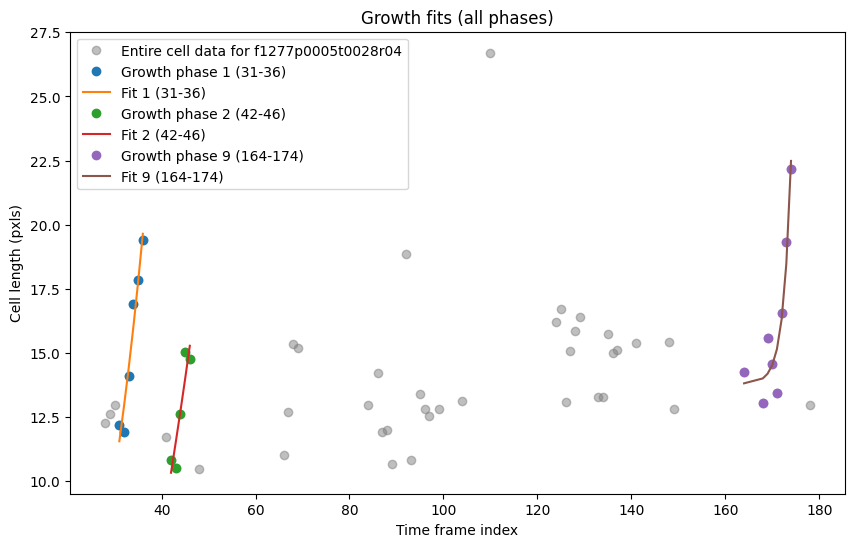

{'prominences': array([1.34139849, 3.06623699, 3.79553234, 0.49853847, 2.80595432,
       1.44112616, 3.07552235, 4.4158756 , 1.74111936]), 'left_bases': array([ 2,  8, 13, 21, 21, 30, 30, 13, 49]), 'right_bases': array([ 8, 13, 43, 25, 43, 39, 43, 49, 53])}
Fitting growth phase 1 from 29 to 44
  Fit parameters: A=17394.95, k=0.0000, b=-17393.70
  R-squared: 0.3830
Fitting growth phase 2 from 44 to 48
  Fit parameters: A=0.01, k=0.1529, b=6.18
  R-squared: 0.8936
Fitting growth phase 3 from 65 to 70
  Fit parameters: A=0.00, k=0.4176, b=10.22
  R-squared: 0.9715
Fitting growth phase 4 from 78 to 87
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 4 (78-87)
Fitting growth phase 5 from 93 to 112
  Fit parameters: A=6979.03, k=0.0000, b=-6975.38
  R-squared: 0.3075
Fitting growth phase 6 from 112 to 116
  Fit parameters: A=0.01, k=0.0684, b=-0.01
  R-squared: 0.7583
Fitting growth phase 7 from 127 to 13

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

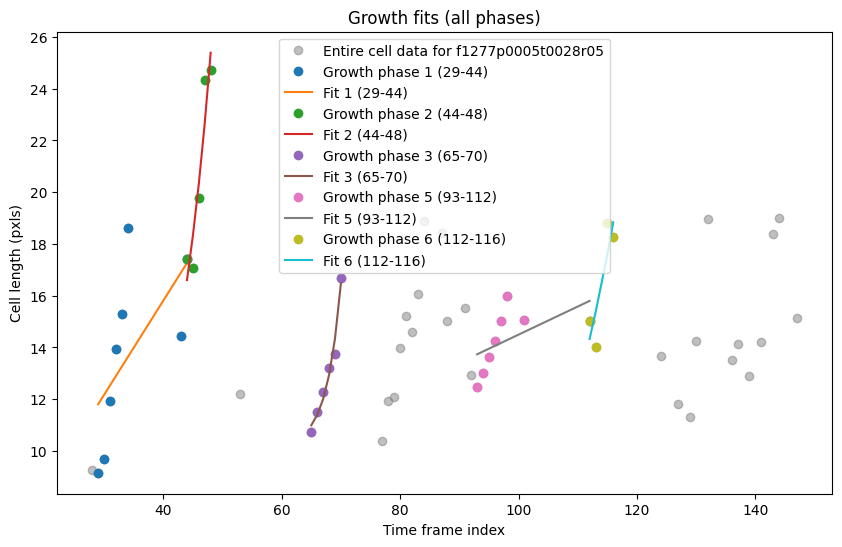

{'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64)}
No growth phases detected.


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

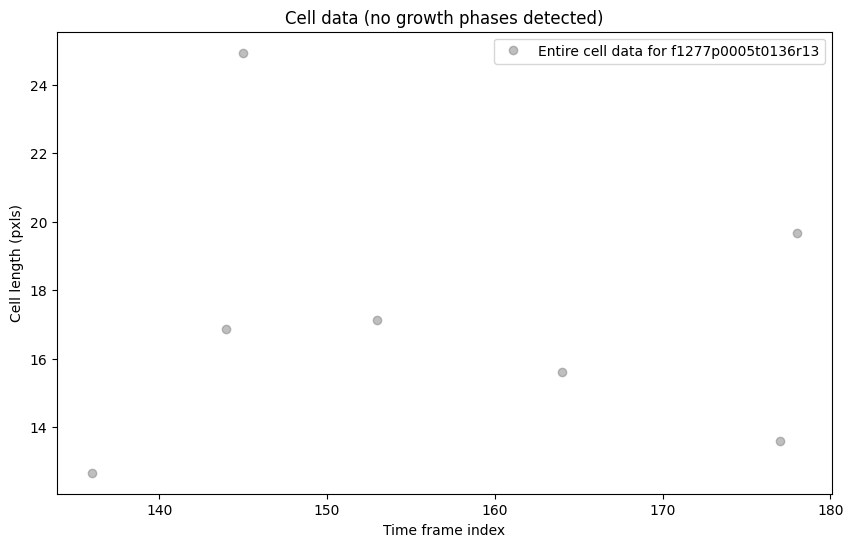

{'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64)}
No growth phases detected.


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

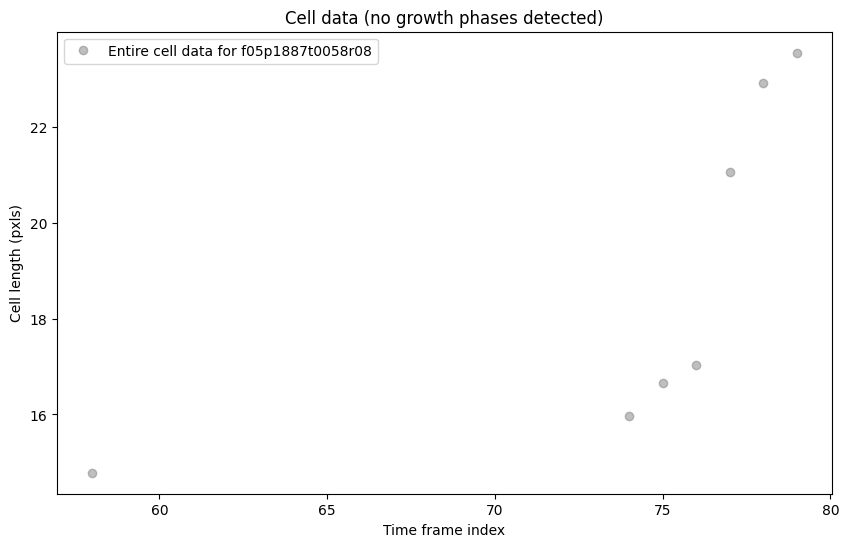

{'prominences': array([0.30403134]), 'left_bases': array([2]), 'right_bases': array([4])}
Fitting growth phase 1 from 59 to 81
  Fit parameters: A=2488.05, k=0.0000, b=-2479.68
  R-squared: 0.1781
Skipping phase 1 (59-81) due to poor fit (R-squared = 0.1781 < 0.3).


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

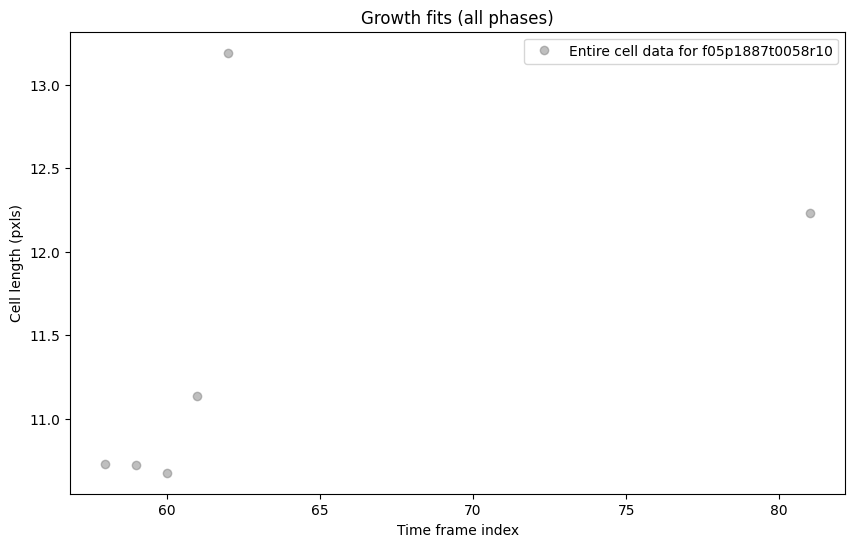

{'prominences': array([2.18728563, 0.58105672]), 'left_bases': array([3, 6]), 'right_bases': array([8, 8])}
Fitting growth phase 1 from 69 to 148
  Fit parameters: A=7386.32, k=0.0000, b=-7380.99
  R-squared: 0.6370


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

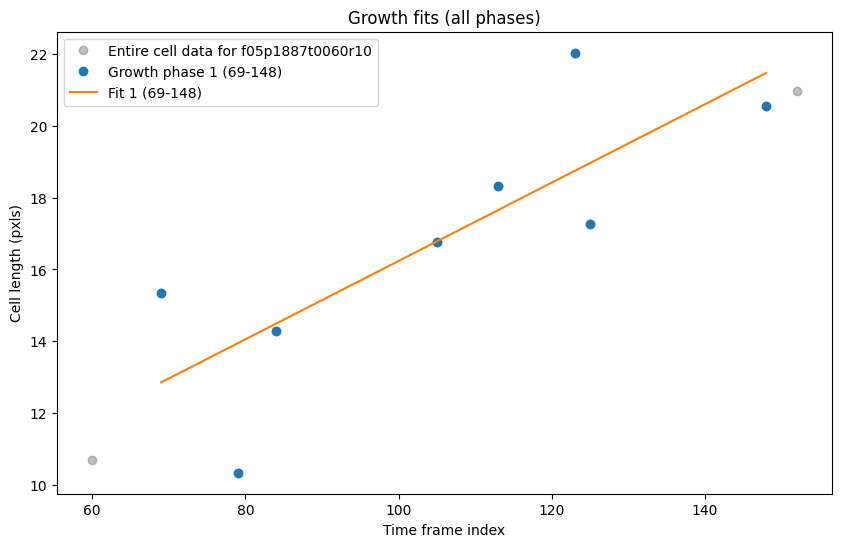

{'prominences': array([0.19345319]), 'left_bases': array([5]), 'right_bases': array([7])}
Fitting growth phase 1 from 65 to 67
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 1 (65-67)


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

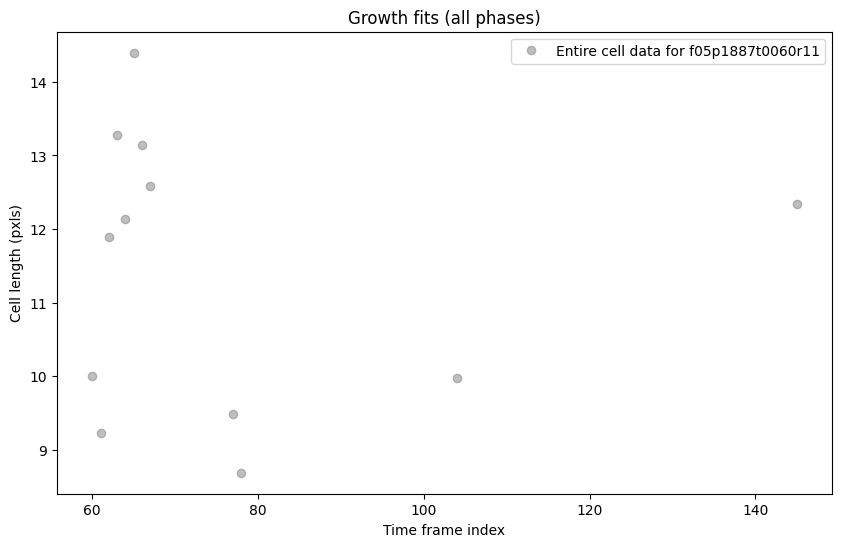

{'prominences': array([1.10580896]), 'left_bases': array([2]), 'right_bases': array([4])}
Fitting growth phase 1 from 68 to 168
  Fit parameters: A=4577.01, k=0.0000, b=-4561.80
  R-squared: 0.0351
Skipping phase 1 (68-168) due to poor fit (R-squared = 0.0351 < 0.3).


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

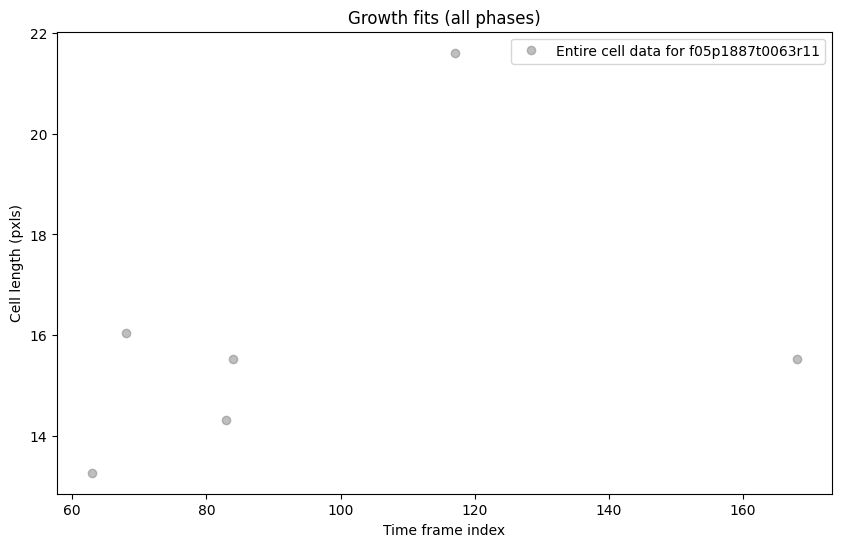

{'prominences': array([0.2739847 , 1.16839675]), 'left_bases': array([3, 3]), 'right_bases': array([ 5, 10])}
Fitting growth phase 1 from 95 to 95
Skipping phase 1 (95-95) due to insufficient data points.
Fitting growth phase 2 from 153 to 156
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 2 (153-156)


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

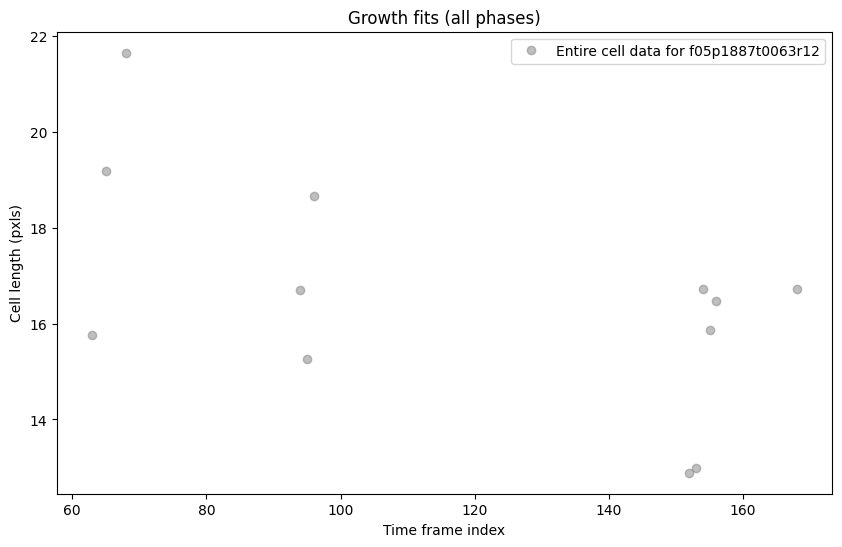

{'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64)}
No growth phases detected.


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

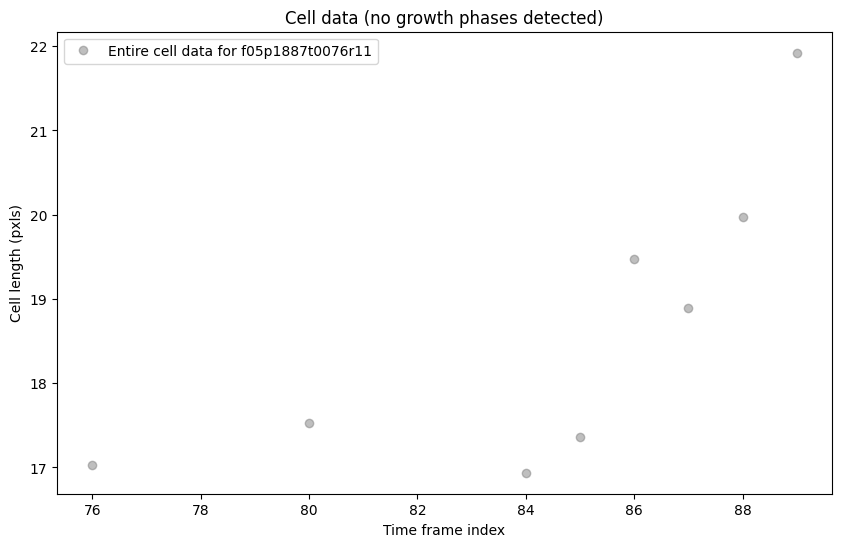

{'prominences': array([4.6171875 , 4.97462346, 3.8984375 , 0.63887915, 2.05195828]), 'left_bases': array([ 2,  7, 11, 15, 15]), 'right_bases': array([ 7, 21, 21, 17, 21])}
Fitting growth phase 1 from 98 to 141
  Fit parameters: A=3177.09, k=0.0000, b=-3171.52
  R-squared: 0.1221
Skipping phase 1 (98-141) due to poor fit (R-squared = 0.1221 < 0.3).
Fitting growth phase 2 from 141 to 147
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 2 (141-147)
Fitting growth phase 3 from 151 to 171
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 3 (151-171)
Fitting growth phase 4 from 171 to 173
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 4 (171-173)
Fitting growth phase 5 from 173 to 178
  Fit parameters: A=0.00, k=0.2695, b=12.13
  R-sq

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

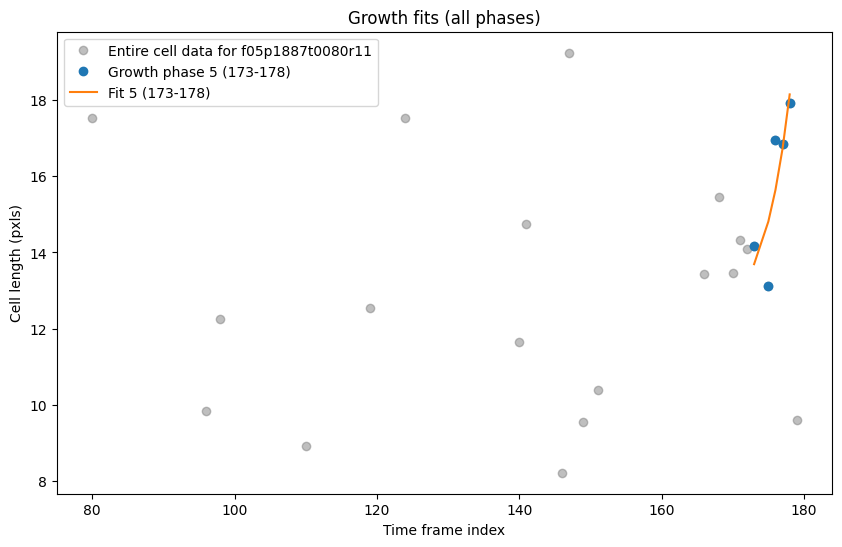

{'prominences': array([0.38101042]), 'left_bases': array([2]), 'right_bases': array([4])}
Fitting growth phase 1 from 81 to 103
  Fit parameters: A=-52.94, k=-0.0000, b=65.12
  R-squared: 0.0008
Skipping phase 1 (81-103) due to poor fit (R-squared = 0.0008 < 0.3).


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

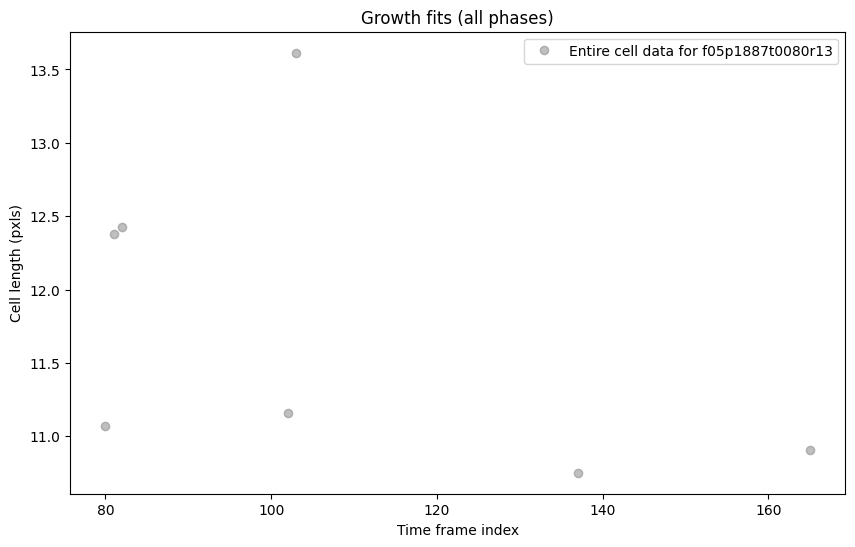

{'prominences': array([1.64342449, 0.52171391]), 'left_bases': array([2, 8]), 'right_bases': array([ 8, 10])}
Fitting growth phase 1 from 98 to 113
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 1 (98-113)
Fitting growth phase 2 from 173 to 173
Skipping phase 2 (173-173) due to insufficient data points.


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

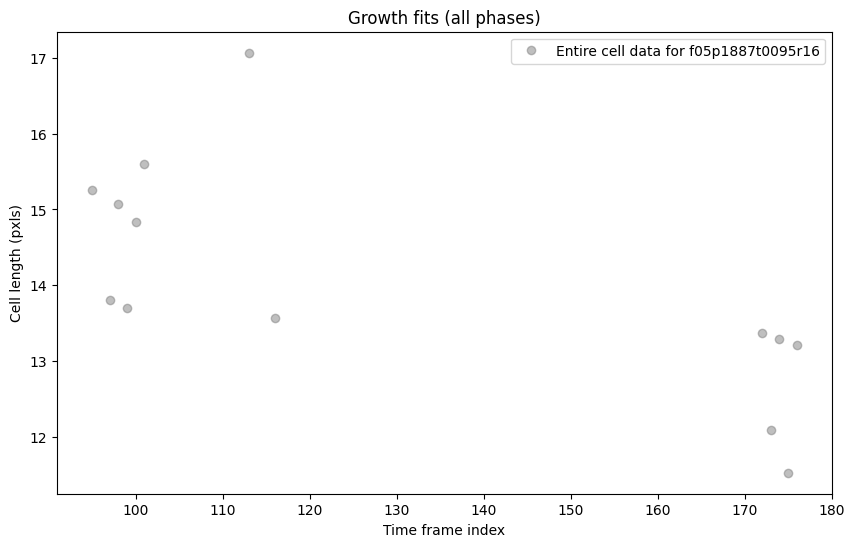

{'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64)}
No growth phases detected.


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

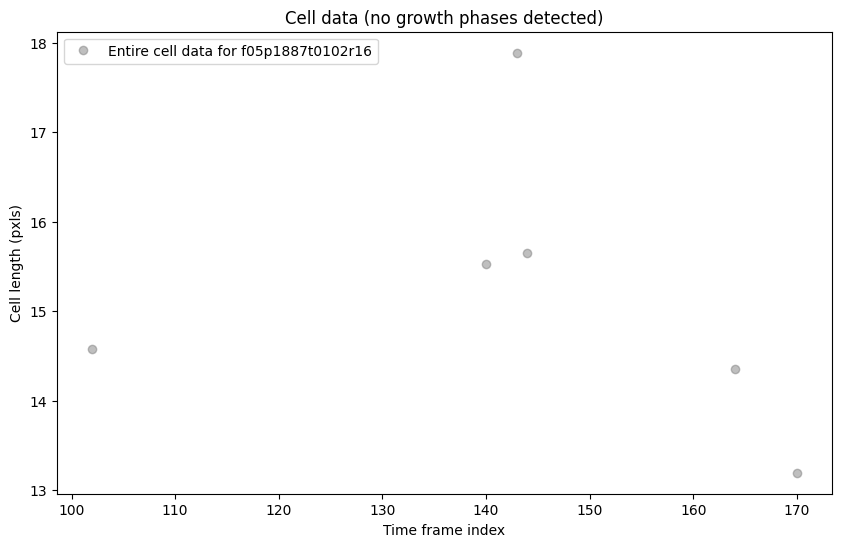

{'prominences': array([0.32552083, 1.57552083, 0.17447917, 0.74739583]), 'left_bases': array([ 2,  6,  9, 14]), 'right_bases': array([ 6, 19, 12, 19])}
Fitting growth phase 1 from 29 to 32
  Fit parameters: A=0.00, k=1.2018, b=13.50
  R-squared: 0.9905
Fitting growth phase 2 from 40 to 53
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 2 (40-53)


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

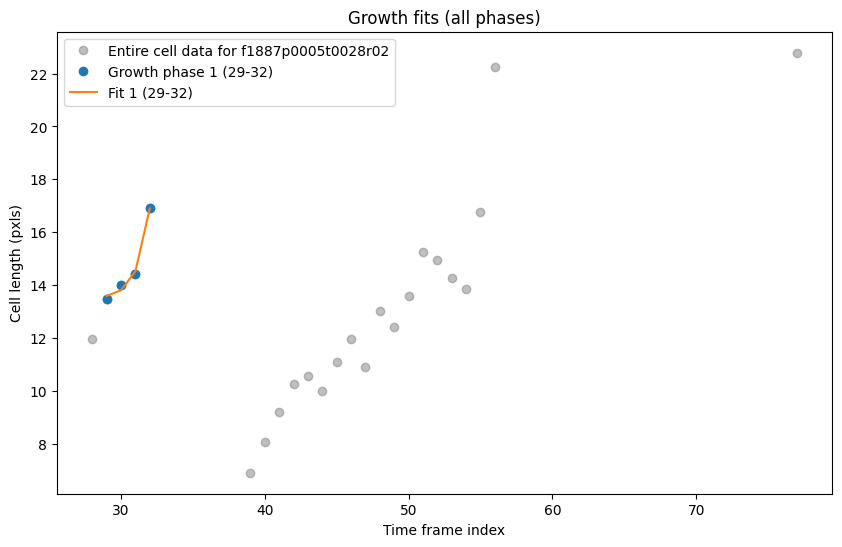

{'prominences': array([2.20833333, 2.36458333, 1.1875    , 4.13541667]), 'left_bases': array([ 4,  4, 20,  4]), 'right_bases': array([ 9, 22, 22, 28])}
Fitting growth phase 1 from 40 to 45
  Fit parameters: A=8640.58, k=0.0001, b=-8652.00
  R-squared: 0.6913
Fitting growth phase 2 from 46 to 55
  Fit parameters: A=11963.95, k=0.0000, b=-11974.17
  R-squared: 0.7196
Fitting growth phase 3 from 57 to 61
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 3 (57-61)
Fitting growth phase 4 from 63 to 66
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 4 (63-66)


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

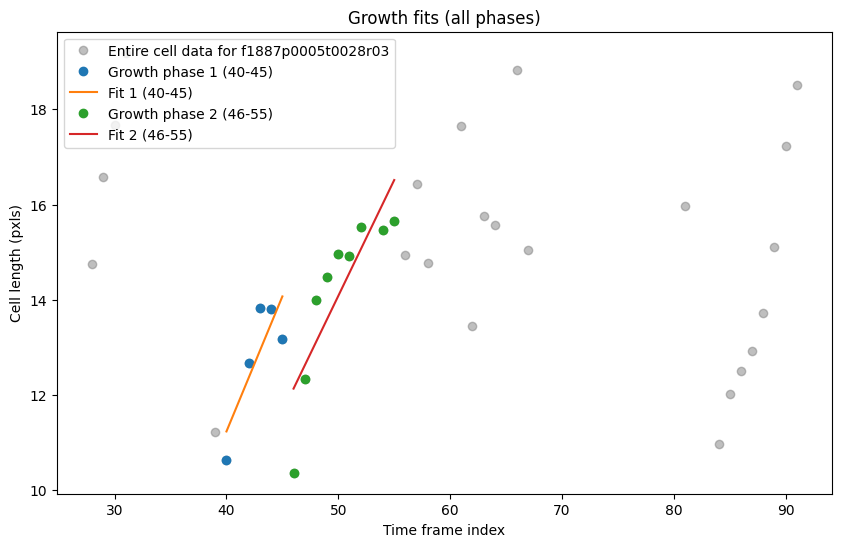

{'prominences': array([2.77994792, 0.57552083, 1.13802083]), 'left_bases': array([ 7, 13,  7]), 'right_bases': array([17, 17, 20])}
Fitting growth phase 1 from 37 to 85
  Fit parameters: A=19061.06, k=0.0000, b=-19054.32
  R-squared: 0.2437
Skipping phase 1 (37-85) due to poor fit (R-squared = 0.2437 < 0.3).
Fitting growth phase 2 from 85 to 170
  Fit parameters: A=2.08, k=0.0095, b=10.00
  R-squared: 0.2450
Skipping phase 2 (85-170) due to poor fit (R-squared = 0.2450 < 0.3).


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

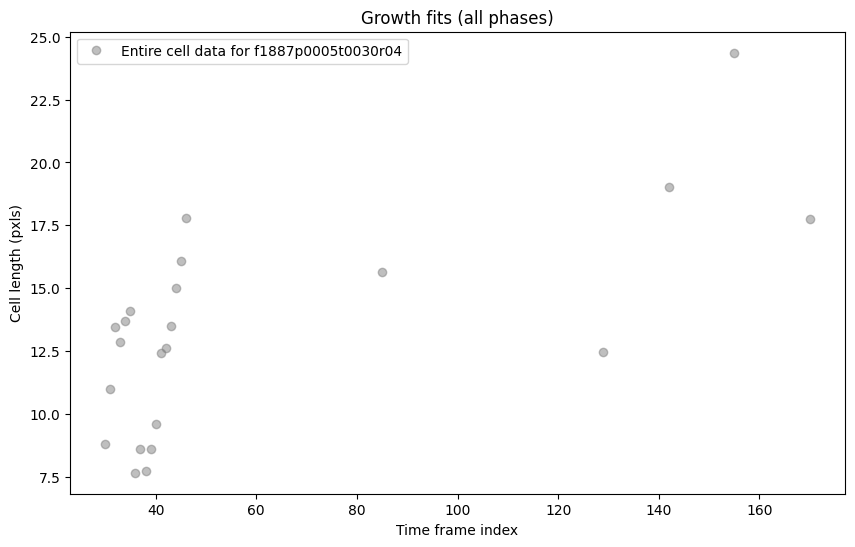

{'prominences': array([ 0.25260417, 10.17777851]), 'left_bases': array([5, 5]), 'right_bases': array([11, 18])}
Fitting growth phase 1 from 44 to 52
  Fit parameters: A=1.63, k=0.0543, b=-6.32
  R-squared: 0.9892
Fitting growth phase 2 from 52 to 140
  Fit parameters: A=0.00, k=0.1014, b=19.15
  R-squared: 0.7358


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

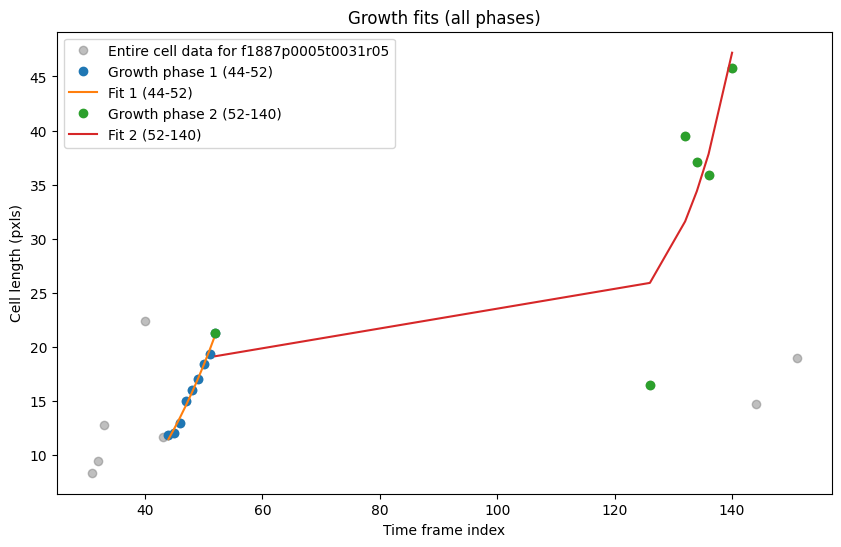

{'prominences': array([1.56584634, 0.44422124]), 'left_bases': array([2, 8]), 'right_bases': array([ 8, 11])}
Fitting growth phase 1 from 38 to 43
  Fit parameters: A=4.42, k=0.0441, b=-13.04
  R-squared: 0.7520
Fitting growth phase 2 from 52 to 76
  Fit parameters: A=0.00, k=0.6210, b=10.50
  R-squared: 0.8818


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

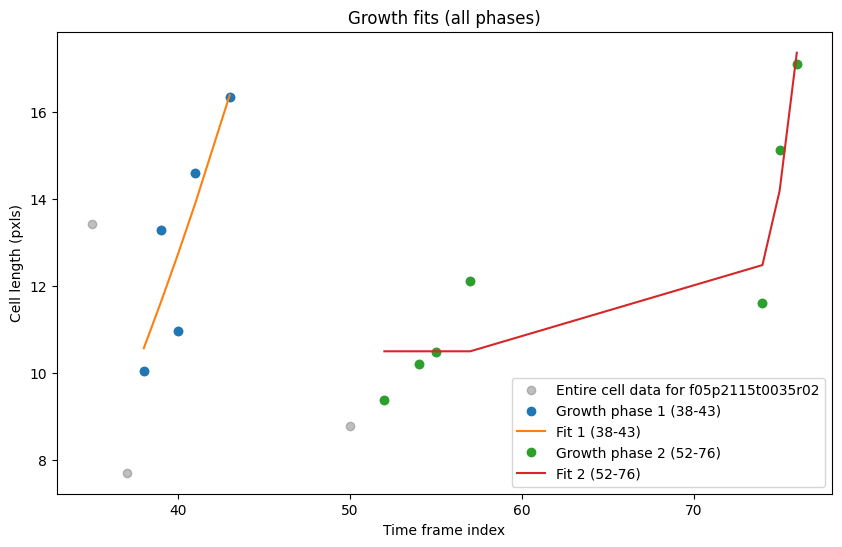

{'prominences': array([1.14128408, 1.68417745]), 'left_bases': array([3, 9]), 'right_bases': array([ 9, 15])}
Fitting growth phase 1 from 37 to 47
  Fit parameters: A=4270.64, k=0.0001, b=-4277.77
  R-squared: 0.6912
Fitting growth phase 2 from 50 to 63
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 2 (50-63)


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

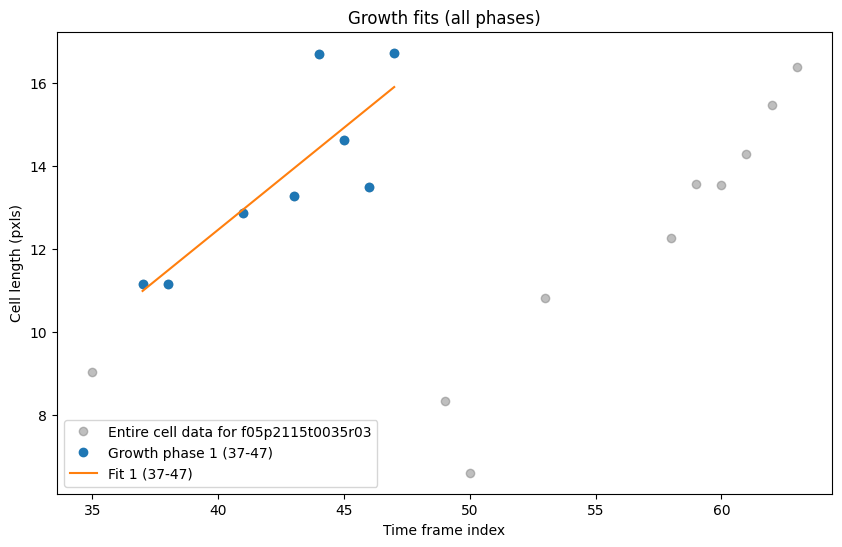

{'prominences': array([0.74920823]), 'left_bases': array([2]), 'right_bases': array([5])}
Fitting growth phase 1 from 52 to 78
  Fit parameters: A=0.00, k=0.1289, b=8.70
  R-squared: 0.9644


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

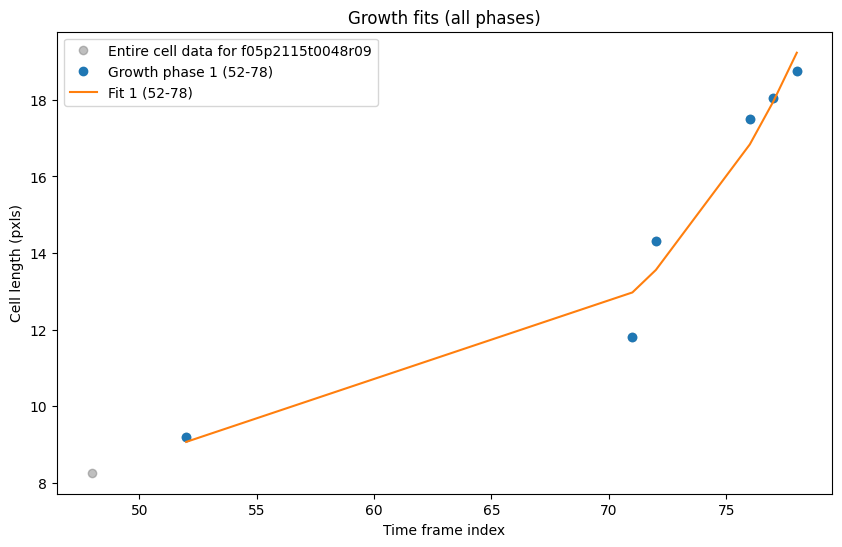

{'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64)}
No growth phases detected.


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

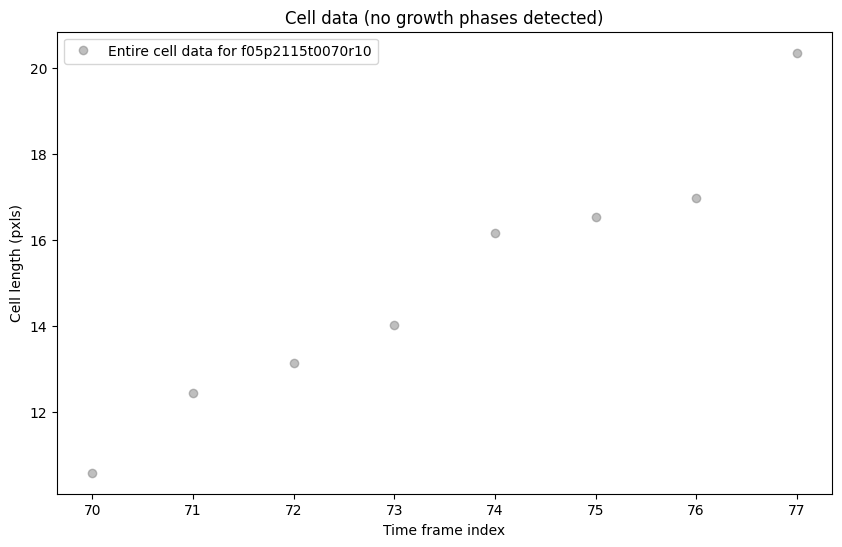

{'prominences': array([0.26822917, 2.89583333, 1.25520833]), 'left_bases': array([ 2,  6, 13]), 'right_bases': array([ 6, 16, 16])}
Fitting growth phase 1 from 29 to 33
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 1 (29-33)
Fitting growth phase 2 from 35 to 64
  Fit parameters: A=16807.79, k=0.0000, b=-16797.37
  R-squared: 0.3691
Fitting growth phase 3 from 64 to 66
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 3 (64-66)


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

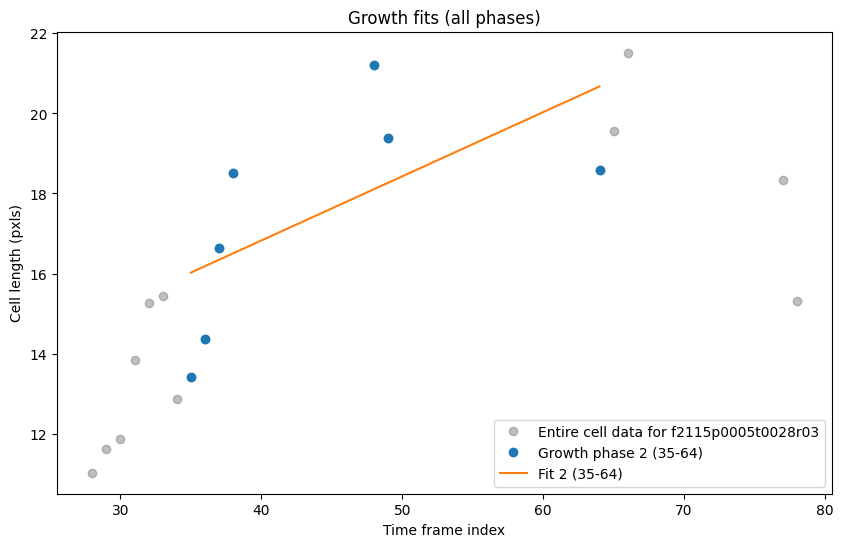

{'prominences': array([1.06510417, 5.69470189]), 'left_bases': array([5, 5]), 'right_bases': array([ 9, 14])}
Fitting growth phase 1 from 36 to 137
  Fit parameters: A=12.64, k=0.0143, b=-11.04
  R-squared: 0.9797


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

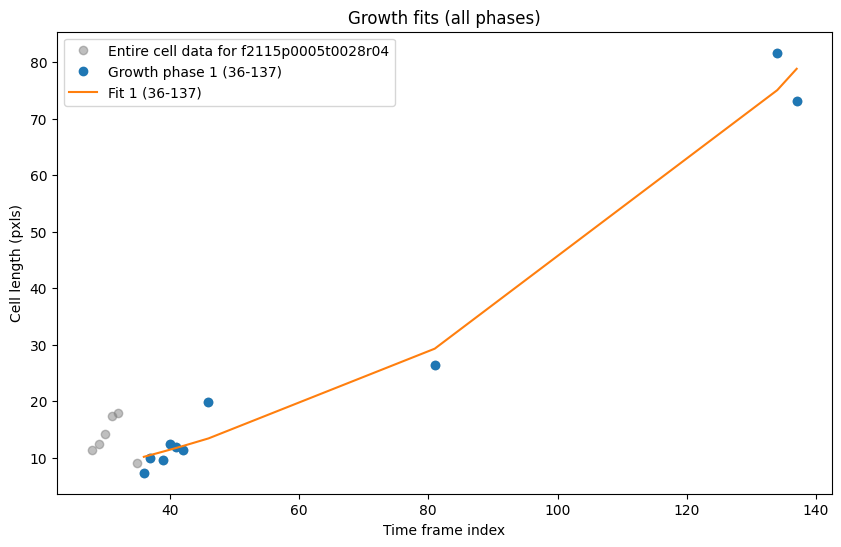

{'prominences': array([4.99627371, 3.64602847]), 'left_bases': array([5, 9]), 'right_bases': array([ 9, 13])}
Fitting growth phase 1 from 41 to 45
  Fit parameters: A=0.00, k=0.4380, b=10.08
  R-squared: 0.8274
Fitting growth phase 2 from 59 to 61
  Fit parameters: A=0.00, k=0.6611, b=14.28
  R-squared: 1.0000


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

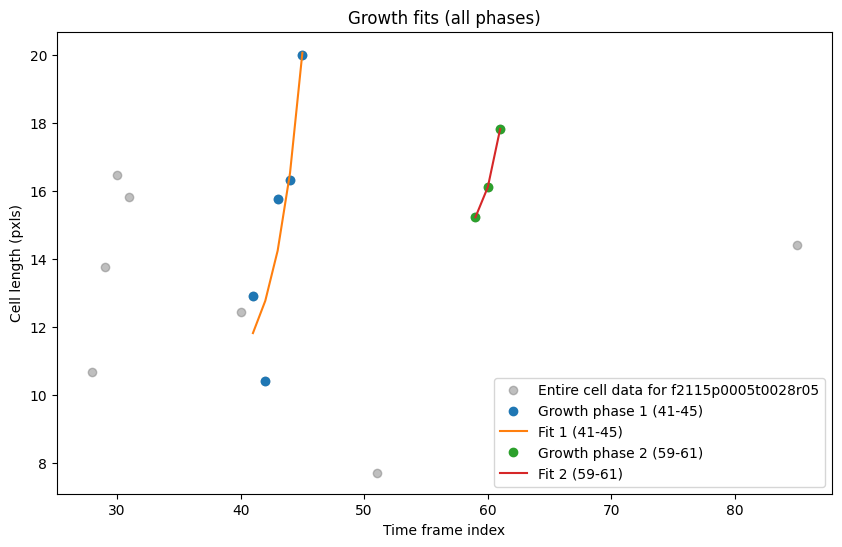

{'prominences': array([6.10896653, 2.16715554]), 'left_bases': array([3, 7]), 'right_bases': array([ 7, 11])}
Fitting growth phase 1 from 38 to 48
  Fit parameters: A=13465.14, k=0.0000, b=-13481.17
  R-squared: 0.1165
Skipping phase 1 (38-48) due to poor fit (R-squared = 0.1165 < 0.3).
Fitting growth phase 2 from 48 to 53
  Fit parameters: A=536.51, k=0.0001, b=-526.34
  R-squared: 0.0983
Skipping phase 2 (48-53) due to poor fit (R-squared = 0.0983 < 0.3).


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

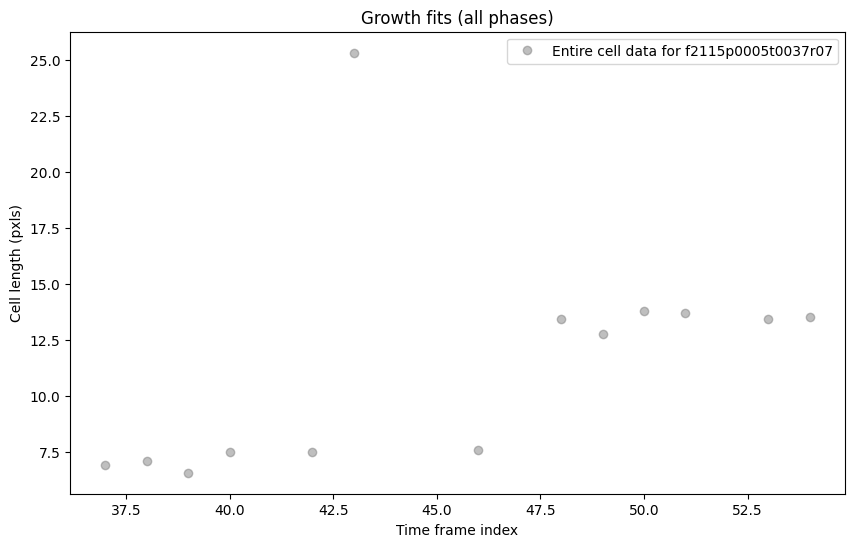

{'prominences': array([0.90364583, 0.33854167, 7.33333333]), 'left_bases': array([ 3, 10, 10]), 'right_bases': array([10, 12, 17])}
Fitting growth phase 1 from 69 to 82
  Fit parameters: A=16497.36, k=0.0000, b=-16509.40
  R-squared: 0.3666
Fitting growth phase 2 from 85 to 94
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 2 (85-94)


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

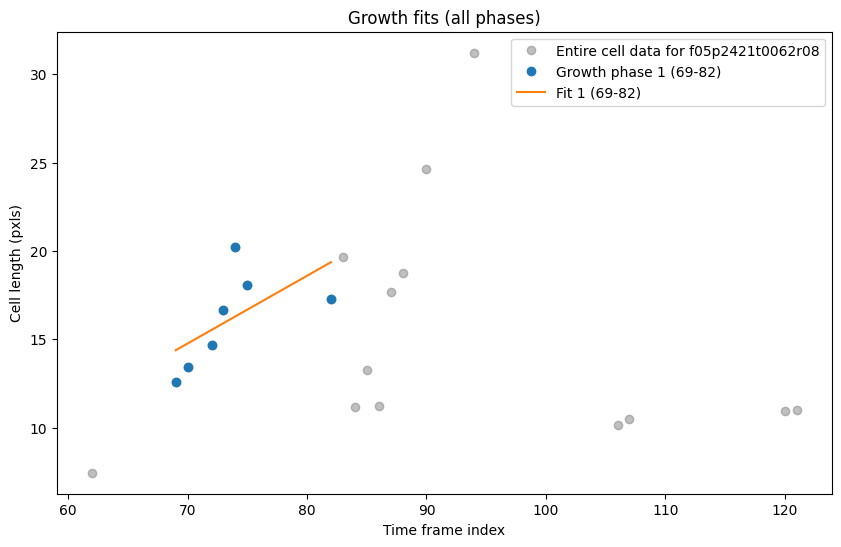

{'prominences': array([1.39192001]), 'left_bases': array([2]), 'right_bases': array([4])}
Fitting growth phase 1 from 85 to 126
  Fit parameters: A=-1083.75, k=0.0000, b=1099.14
  R-squared: 0.1230
Skipping phase 1 (85-126) due to poor fit (R-squared = 0.1230 < 0.3).


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

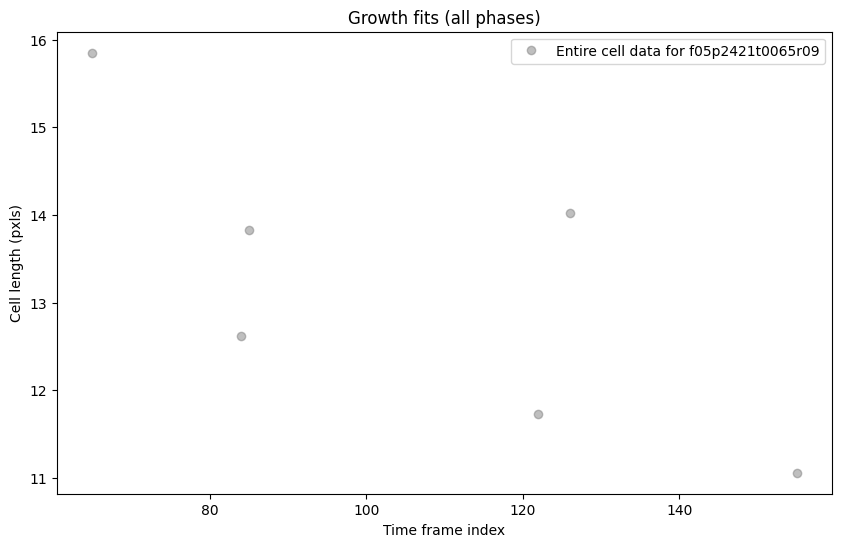

{'prominences': array([0.68999016, 1.81926265]), 'left_bases': array([2, 6]), 'right_bases': array([10, 10])}
Fitting growth phase 1 from 70 to 99
  Fit parameters: A=5744.08, k=0.0000, b=-5736.41
  R-squared: 0.3673
Fitting growth phase 2 from 100 to 134
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 2 (100-134)


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

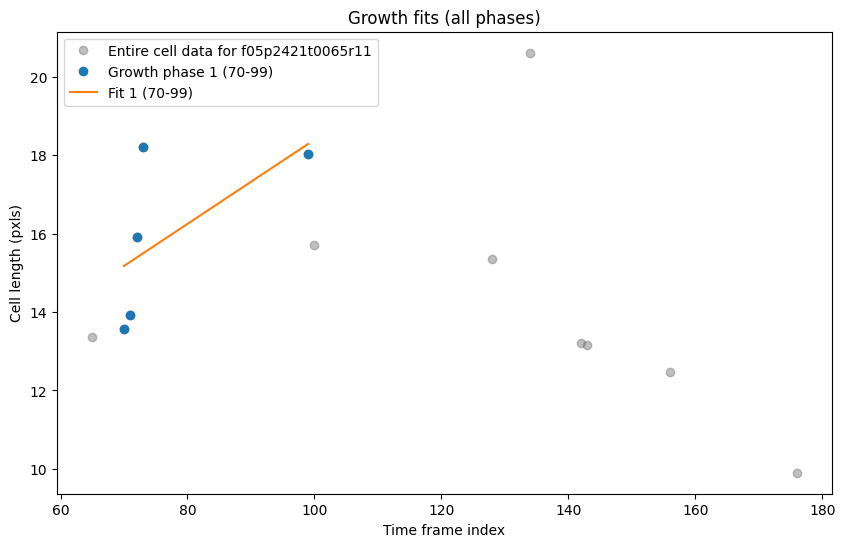

{'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64)}
No growth phases detected.


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

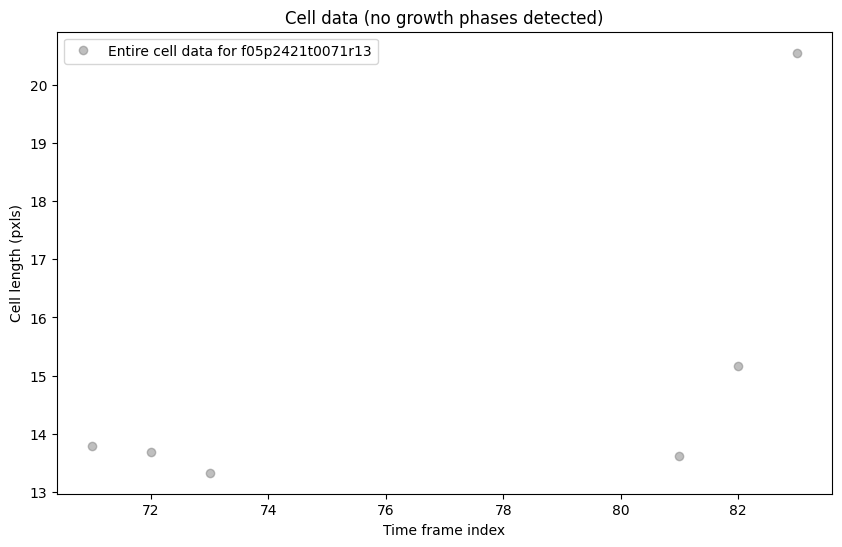

{'prominences': array([3.54370359]), 'left_bases': array([2]), 'right_bases': array([5])}
Fitting growth phase 1 from 84 to 153
  Fit parameters: A=2416.61, k=0.0000, b=-2404.14
  R-squared: 0.0114
Skipping phase 1 (84-153) due to poor fit (R-squared = 0.0114 < 0.3).


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

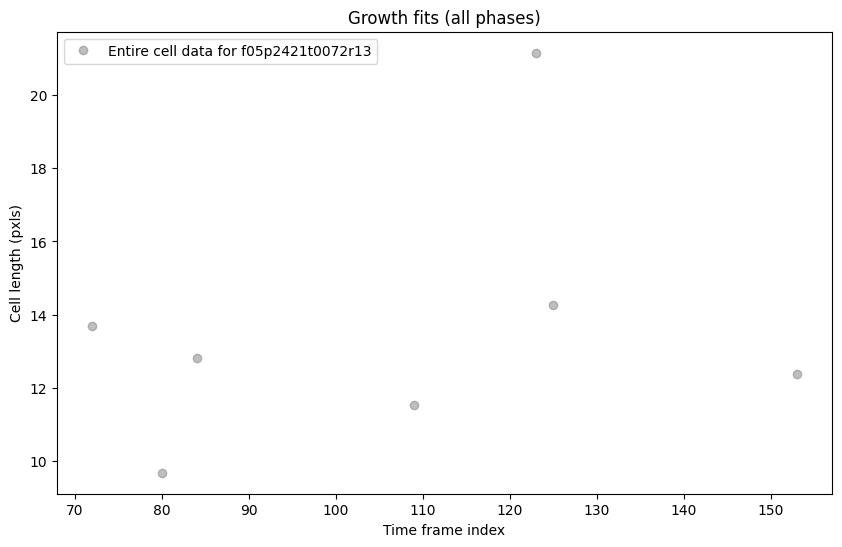

{'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64)}
No growth phases detected.


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

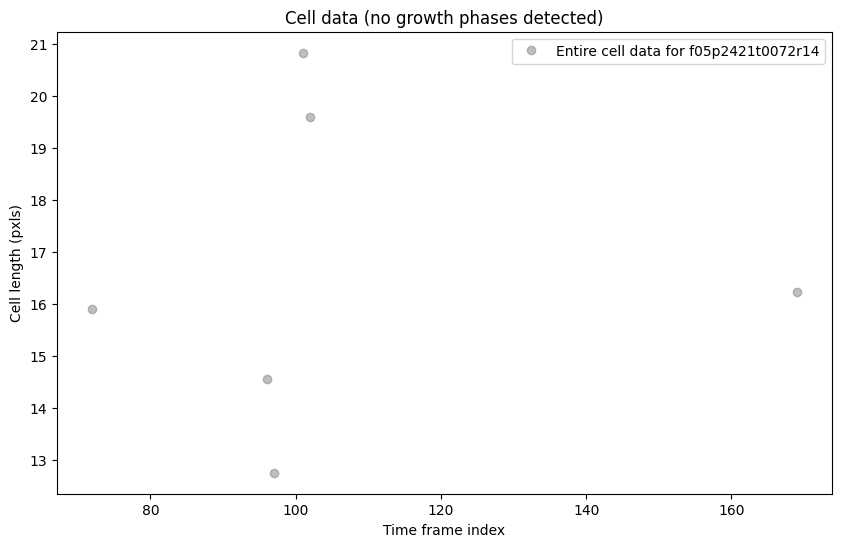

{'prominences': array([1.8515625]), 'left_bases': array([3]), 'right_bases': array([6])}
Fitting growth phase 1 from 111 to 149
  Fit parameters: A=7457.91, k=0.0000, b=-7456.54
  R-squared: 0.3471


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

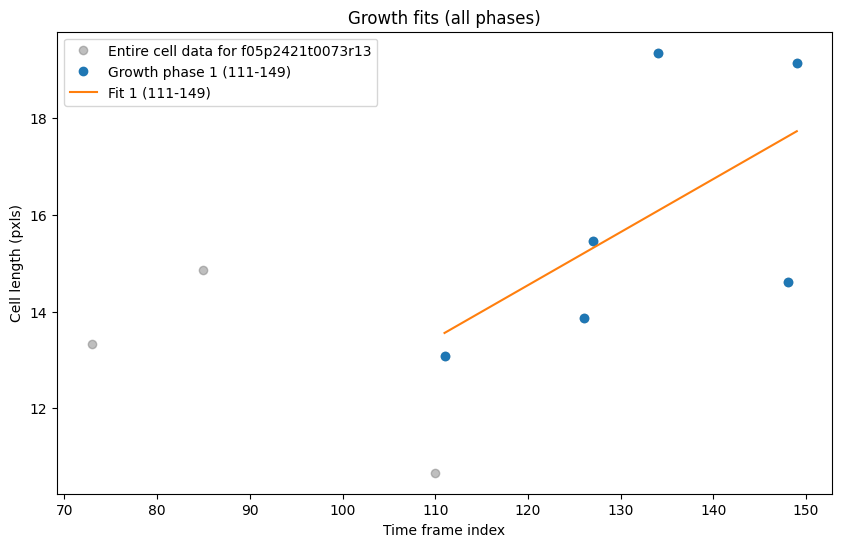

{'prominences': array([0.30111173, 1.60273468]), 'left_bases': array([2, 6]), 'right_bases': array([ 6, 10])}
Fitting growth phase 1 from 113 to 113
Skipping phase 1 (113-113) due to insufficient data points.
Fitting growth phase 2 from 137 to 157
  Fit parameters: A=0.00, k=0.7806, b=11.05
  R-squared: 0.9807


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

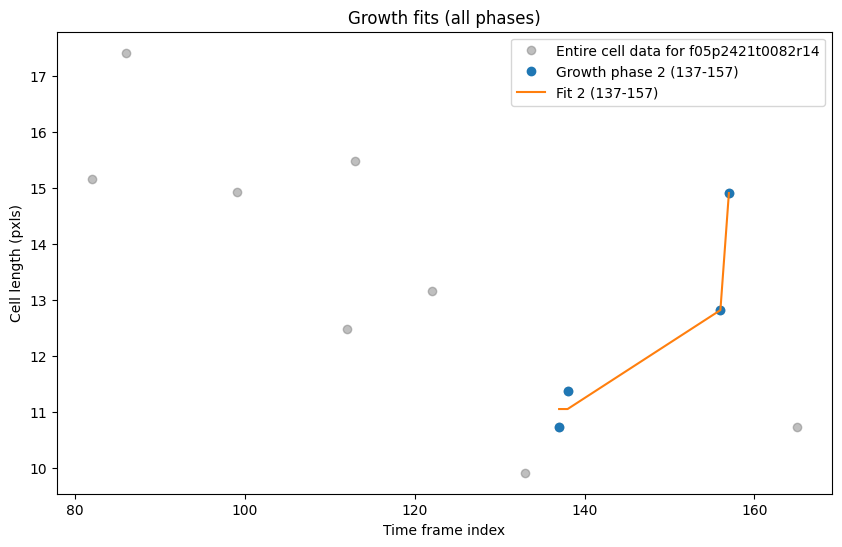

{'prominences': array([0.31857857, 0.93962599]), 'left_bases': array([2, 2]), 'right_bases': array([ 5, 12])}
Fitting growth phase 1 from 106 to 132
  Fit parameters: A=35320.85, k=0.0000, b=-35357.55
  R-squared: 0.6176


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

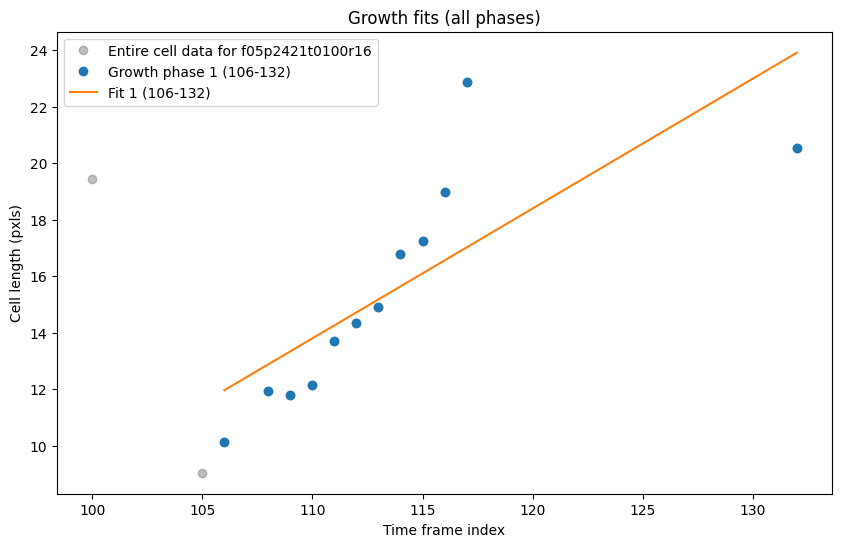

{'prominences': array([1.87414374, 0.11287346, 1.75994997, 0.9027348 ]), 'left_bases': array([ 3,  7,  7, 17]), 'right_bases': array([ 7, 12, 17, 20])}
Fitting growth phase 1 from 135 to 150
  Fit parameters: A=6690.75, k=0.0000, b=-6701.73
  R-squared: 0.1954
Skipping phase 1 (135-150) due to poor fit (R-squared = 0.1954 < 0.3).
Fitting growth phase 2 from 153 to 179
  Fit parameters: A=0.00, k=0.0549, b=7.38
  R-squared: 0.8858


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

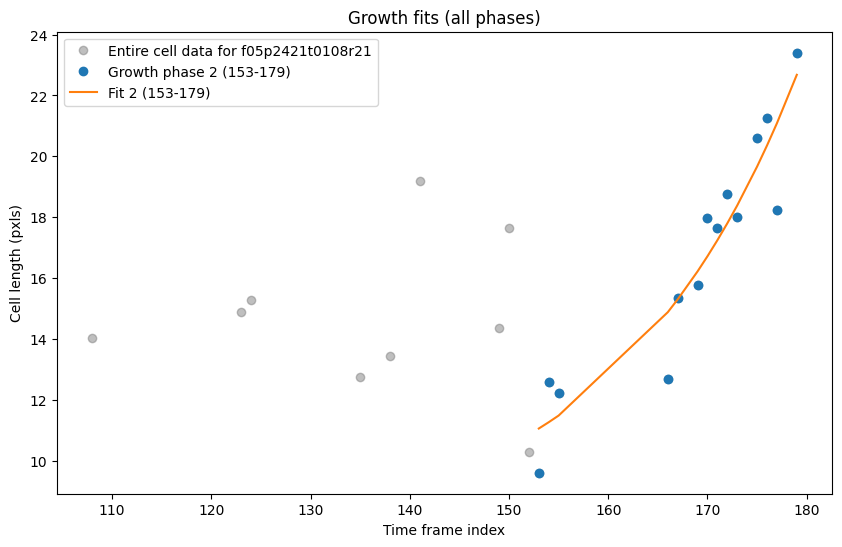

{'prominences': array([1.08593138, 1.57779781]), 'left_bases': array([5, 8]), 'right_bases': array([ 8, 13])}
Fitting growth phase 1 from 138 to 140
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 1 (138-140)
Fitting growth phase 2 from 169 to 174
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 2 (169-174)


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

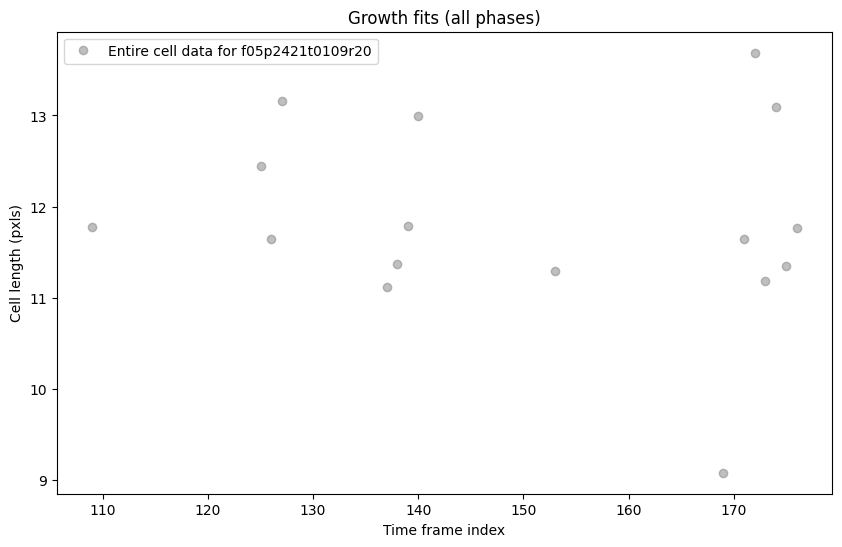

{'prominences': array([0.695769]), 'left_bases': array([3]), 'right_bases': array([7])}
Fitting growth phase 1 from 129 to 161
  Fit parameters: A=0.00, k=0.0806, b=12.87
  R-squared: 0.8427


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

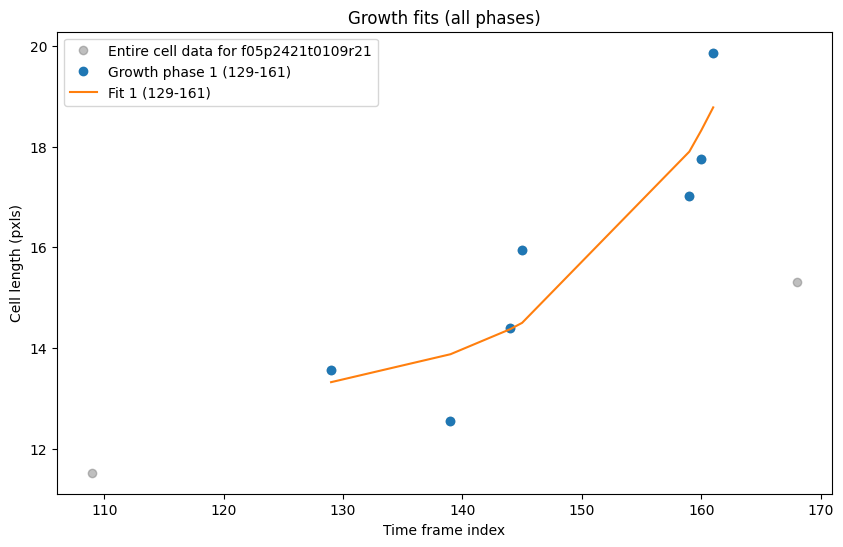

{'prominences': array([2.17219801]), 'left_bases': array([3]), 'right_bases': array([9])}
Fitting growth phase 1 from 131 to 143
  Fit parameters: A=0.00, k=0.5604, b=13.59
  R-squared: 0.9991


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

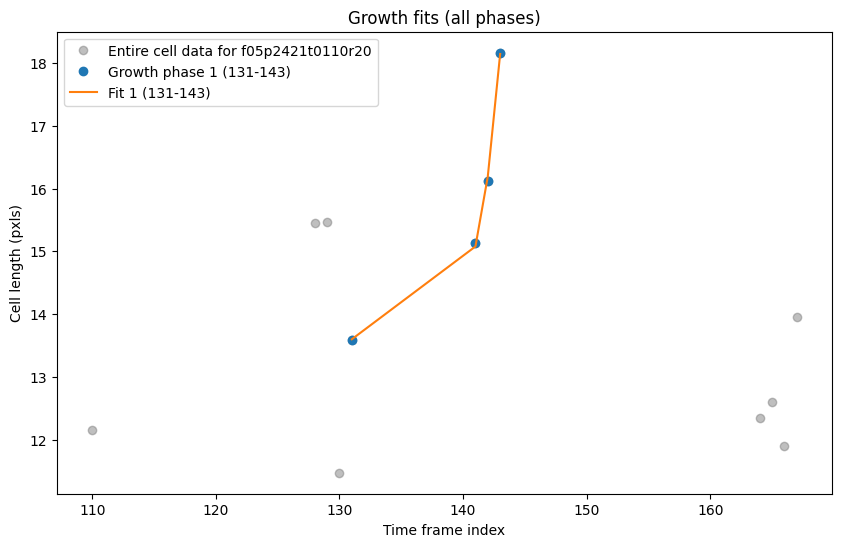

{'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64)}
No growth phases detected.


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

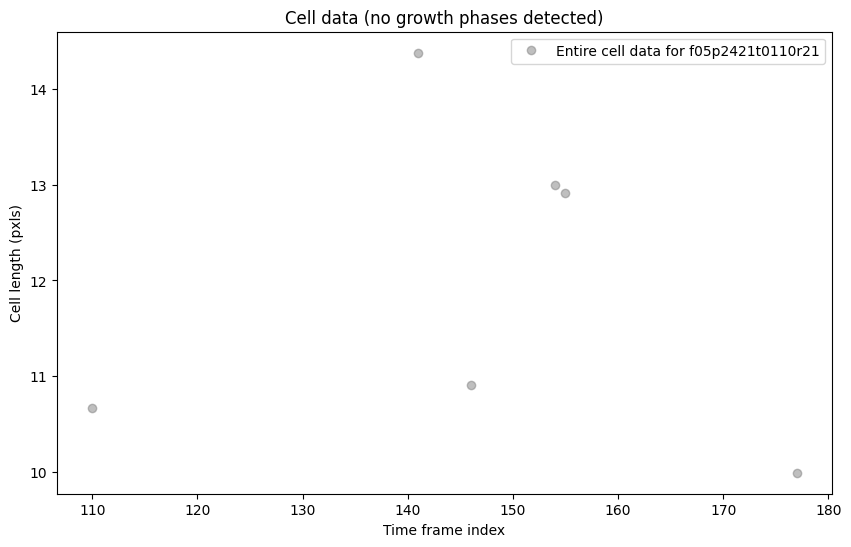

{'prominences': array([1.82291667, 5.82552083, 1.76690214]), 'left_bases': array([ 4,  4, 17]), 'right_bases': array([10, 17, 21])}
Fitting growth phase 1 from 37 to 45


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

  Fit parameters: A=15650.92, k=0.0000, b=-15663.65
  R-squared: 0.7039
Fitting growth phase 2 from 45 to 79
  Fit parameters: A=31036.26, k=0.0000, b=-31030.75
  R-squared: 0.5082
Fitting growth phase 3 from 83 to 120
  Fit parameters: A=7011.25, k=0.0000, b=-7002.19
  R-squared: 0.5232


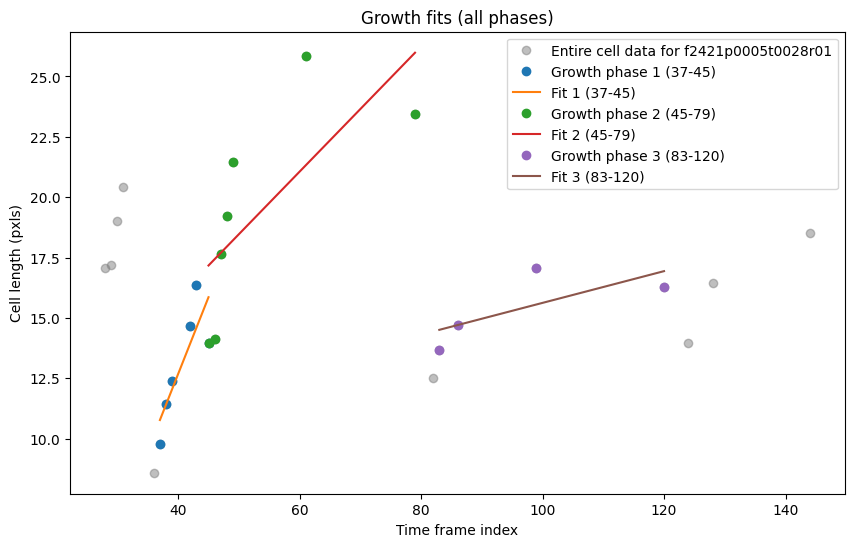

{'prominences': array([1.26822917, 2.73958333, 0.22395833, 3.52604167, 0.609375  ]), 'left_bases': array([ 3,  3, 12,  3, 20]), 'right_bases': array([ 7, 12, 15, 24, 24])}
Fitting growth phase 1 from 38 to 40
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 1 (38-40)
Fitting growth phase 2 from 40 to 44
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 2 (40-44)
Fitting growth phase 3 from 46 to 60
  Fit parameters: A=37932.67, k=0.0000, b=-37966.22
  R-squared: 0.9202


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

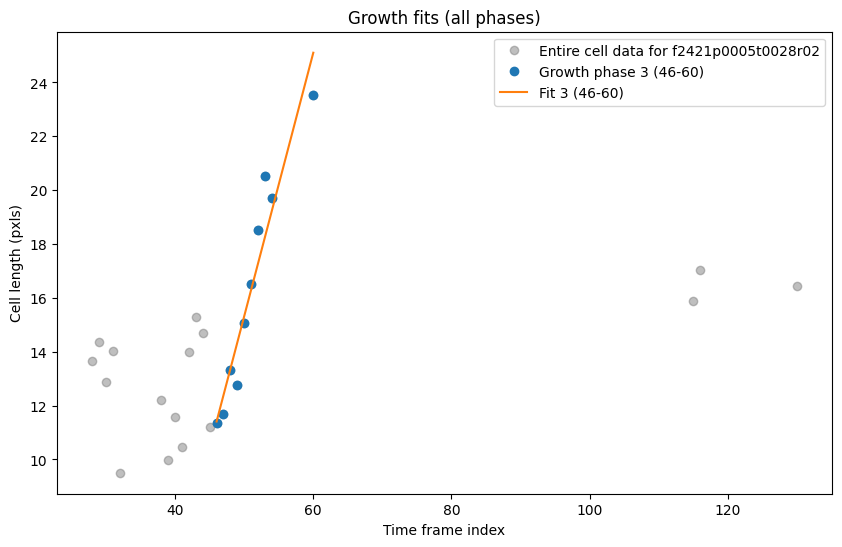

{'prominences': array([2.74739583, 1.21614583, 5.21614583, 0.84114583, 3.6015625 ,
       4.8125    , 3.13541667]), 'left_bases': array([ 2,  8,  8, 21, 21, 21, 35]), 'right_bases': array([41, 14, 41, 24, 28, 41, 41])}
Fitting growth phase 1 from 31 to 39
  Fit parameters: A=16139.97, k=0.0001, b=-16148.78
  R-squared: 0.6443
Fitting growth phase 2 from 44 to 57
  Fit parameters: A=-0.00, k=0.4470, b=15.80
  R-squared: 0.1029
Skipping phase 2 (44-57) due to poor fit (R-squared = 0.1029 < 0.3).
Fitting growth phase 3 from 57 to 74
  Fit parameters: A=33857.98, k=0.0000, b=-33868.72
  R-squared: 0.4951
Fitting growth phase 4 from 85 to 85
Skipping phase 4 (85-85) due to insufficient data points.
Fitting growth phase 5 from 97 to 100


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 5 (97-100)
Fitting growth phase 6 from 106 to 125
  Fit parameters: A=5133.94, k=0.0000, b=-5129.57
  R-squared: 0.0930
Skipping phase 6 (106-125) due to poor fit (R-squared = 0.0930 < 0.3).
Fitting growth phase 7 from 126 to 143
  Fit parameters: A=11229.66, k=0.0000, b=-11246.40
  R-squared: 0.3938


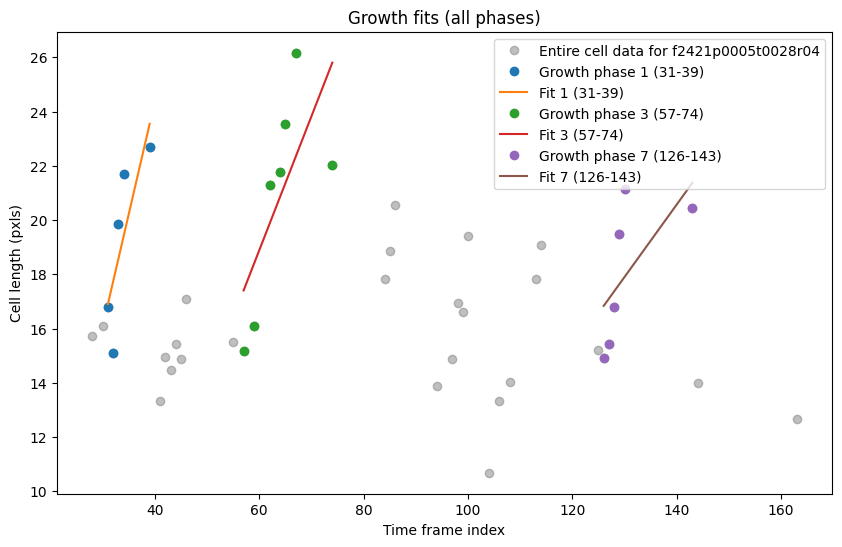

{'prominences': array([1.04745342, 0.61491078, 1.64198248, 1.1275878 ]), 'left_bases': array([ 3,  7,  7, 15]), 'right_bases': array([15, 11, 15, 19])}


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

Fitting growth phase 1 from 31 to 43
  Fit parameters: A=11497.60, k=0.0000, b=-11502.21
  R-squared: 0.7624
Fitting growth phase 2 from 45 to 53
  Fit parameters: A=-0.20, k=0.0704, b=19.96
  R-squared: 1.0000
Fitting growth phase 3 from 53 to 59
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 3 (53-59)
Fitting growth phase 4 from 62 to 70
  Fit parameters: A=0.74, k=0.0600, b=-22.75
  R-squared: 0.9857


/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


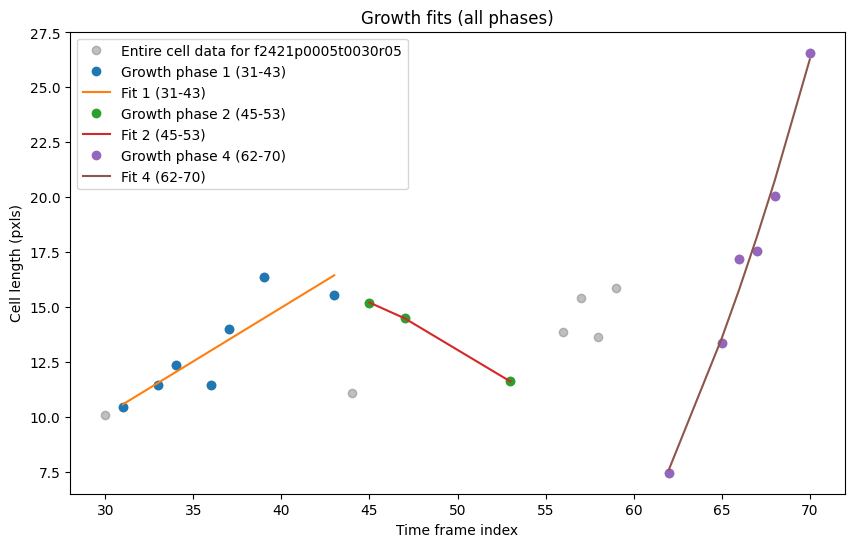

{'prominences': array([1.93119187, 1.24000291, 1.60947858, 1.89619342, 0.39143076]), 'left_bases': array([ 2,  6, 11, 18, 25]), 'right_bases': array([18, 18, 18, 25, 27])}
Fitting growth phase 1 from 42 to 54
  Fit parameters: A=25397.13, k=0.0000, b=-25413.49
  R-squared: 0.7085
Fitting growth phase 2 from 54 to 59
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 2 (54-59)
Fitting growth phase 3 from 98 to 124
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 3 (98-124)
Fitting growth phase 4 from 129 to 158
  Fit parameters: A=0.01, k=0.0368, b=12.39
  R-squared: 0.0927
Skipping phase 4 (129-158) due to poor fit (R-squared = 0.0927 < 0.3).


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

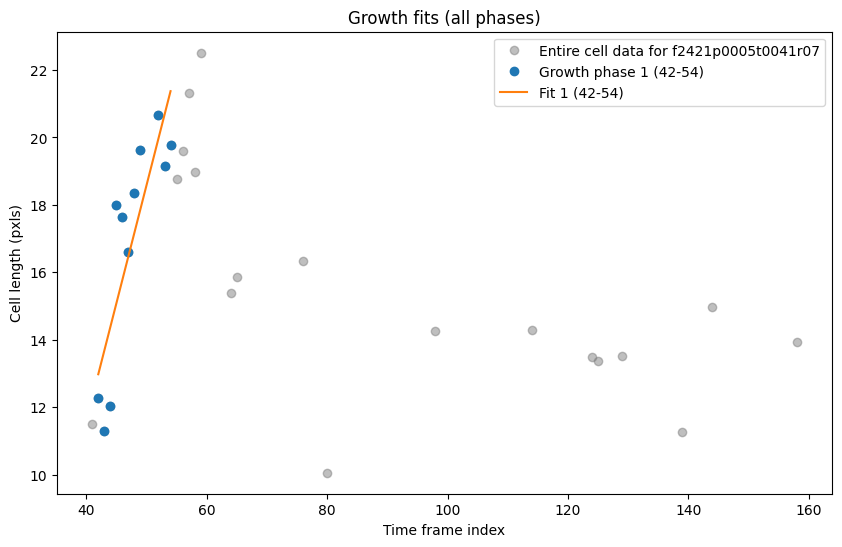

{'prominences': array([2.41248076, 1.49593825, 0.26720094, 5.74262611]), 'left_bases': array([ 2,  7, 11,  7]), 'right_bases': array([ 7, 11, 14, 20])}
Fitting growth phase 1 from 67 to 72
  Fit parameters: A=0.00, k=0.4439, b=11.07
  R-squared: 0.7988
Fitting growth phase 2 from 82 to 97
  Fit parameters: A=0.00, k=0.0944, b=7.52
  R-squared: 0.9739


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

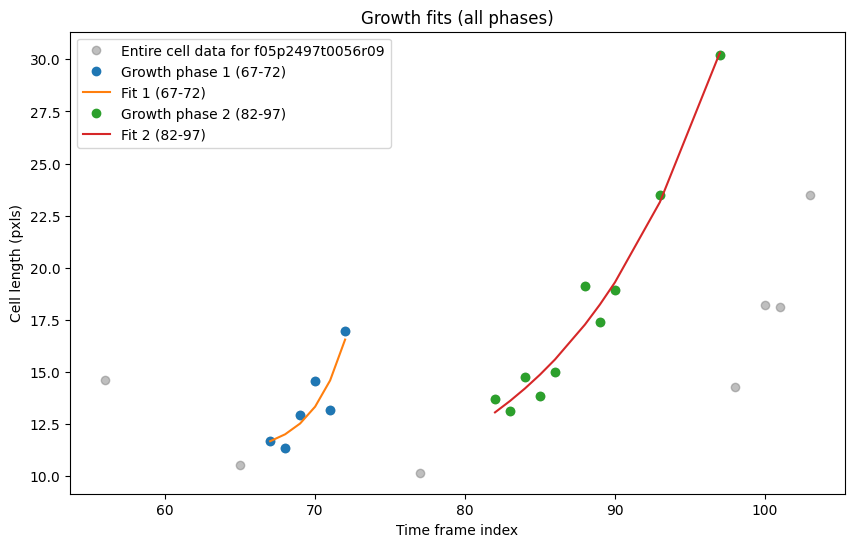

{'prominences': array([0.75762834, 0.90305734, 3.4863362 , 0.56114222]), 'left_bases': array([ 2,  5,  5, 17]), 'right_bases': array([ 5, 11, 20, 20])}
Fitting growth phase 1 from 106 to 118
  Fit parameters: A=8840.25, k=0.0000, b=-8860.22
  R-squared: 0.1512
Skipping phase 1 (106-118) due to poor fit (R-squared = 0.1512 < 0.3).
Fitting growth phase 2 from 121 to 144
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 2 (121-144)
Fitting growth phase 3 from 153 to 153
Skipping phase 3 (153-153) due to insufficient data points.


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

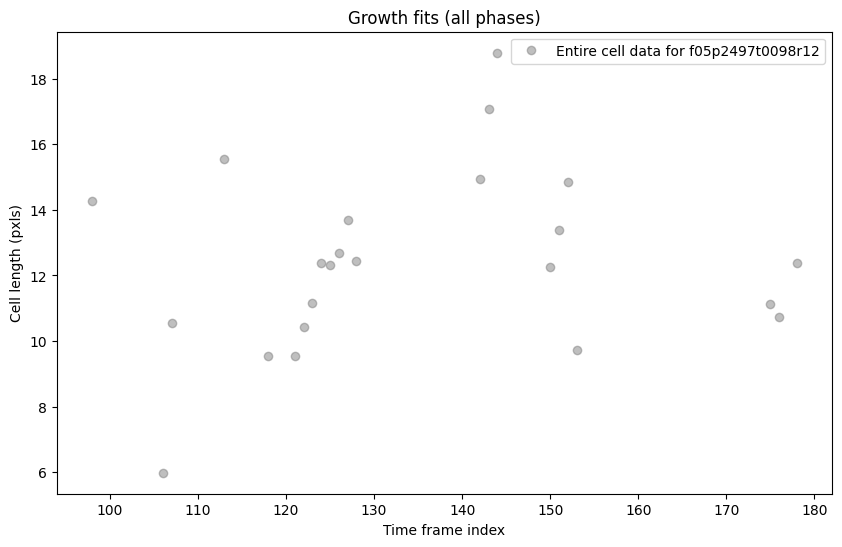

{'prominences': array([2.60362045, 1.3524626 , 0.49438734]), 'left_bases': array([ 3, 12, 14]), 'right_bases': array([12, 17, 17])}
Fitting growth phase 1 from 148 to 154
  Fit parameters: A=0.00, k=0.3181, b=10.31
  R-squared: 0.9010
Fitting growth phase 2 from 160 to 175
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 2 (160-175)
Fitting growth phase 3 from 176 to 178
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 3 (176-178)


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

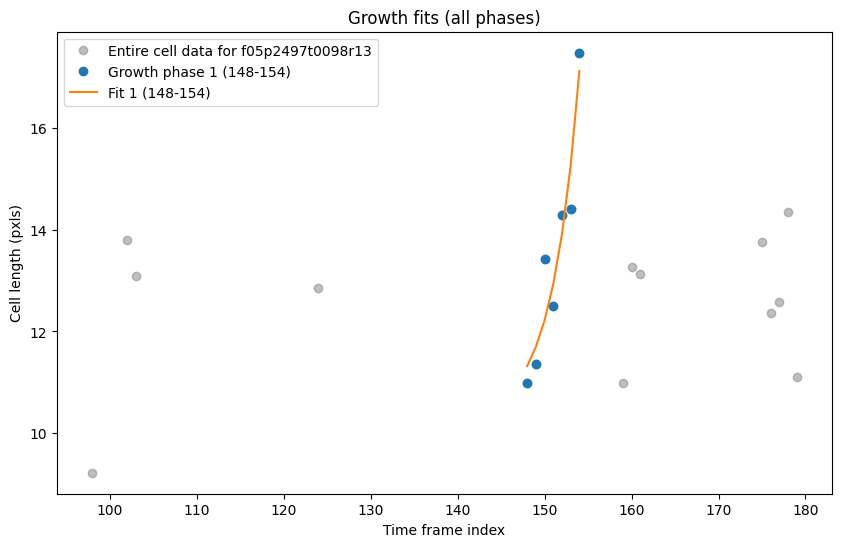

{'prominences': array([0.58165676, 1.9625091 ]), 'left_bases': array([3, 3]), 'right_bases': array([ 5, 12])}
Fitting growth phase 1 from 32 to 34
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 1 (32-34)
Fitting growth phase 2 from 34 to 41
  Fit parameters: A=9376.67, k=0.0001, b=-9391.80
  R-squared: 0.8194


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

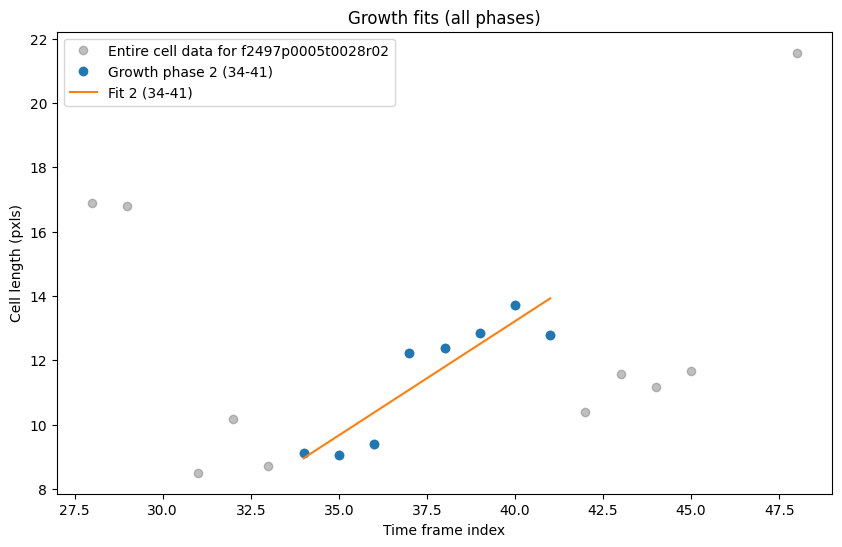

{'prominences': array([0.31316087, 0.52995742, 2.2452605 , 0.94270635]), 'left_bases': array([ 3,  3,  3, 15]), 'right_bases': array([ 5, 10, 15, 19])}
Fitting growth phase 1 from 38 to 49
  Fit parameters: A=0.00, k=0.3697, b=8.41
  R-squared: 0.9178
Fitting growth phase 2 from 51 to 61
  Fit parameters: A=0.00, k=0.1969, b=8.98
  R-squared: 0.9662


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

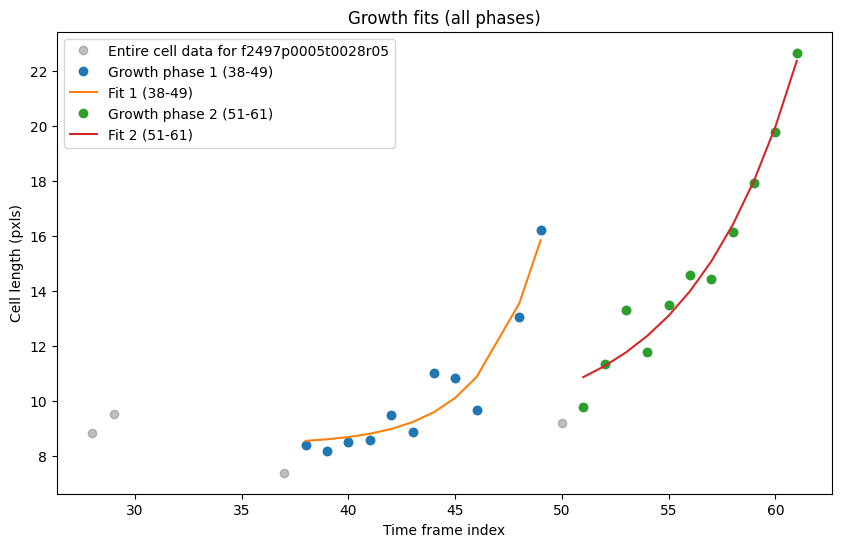

{'prominences': array([0.67708333, 1.7734375 , 3.94791667, 0.296875  , 0.9921875 ,
       0.1171875 , 4.58072917, 3.18569654, 3.57639971, 1.39676727,
       0.79177981, 2.30857764]), 'left_bases': array([ 2,  2,  8, 14, 18, 26, 18, 33, 33, 46, 49, 46]), 'right_bases': array([ 5,  8, 18, 18, 28, 28, 33, 39, 46, 51, 51, 55])}
Fitting growth phase 1 from 29 to 36
  Fit parameters: A=0.01, k=0.1971, b=8.27
  R-squared: 0.9722
Fitting growth phase 2 from 43 to 47
  Fit parameters: A=4536.54, k=0.0001, b=-4533.35
  R-squared: 0.5142
Fitting growth phase 3 from 47 to 49
  Fit parameters: A=0.00, k=1.5362, b=18.11
  R-squared: 1.0000
Fitting growth phase 4 from 75 to 100
  Fit parameters: A=26910.98, k=0.0000, b=-26924.30
  R-squared: 0.5191
Fitting growth phase 5 from 107 to 113
  Fit parameters: A=0.00, k=0.5581, b=15.18
  R-squared: 0.9370
Fitting growth phase 6 from 122 to 126
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
 

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 7 (135-139)
Fitting growth phase 8 from 139 to 148
  Fit parameters: A=-2048.56, k=0.0001, b=2085.69
  R-squared: 0.4627
Fitting growth phase 9 from 148 to 152
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 9 (148-152)


/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


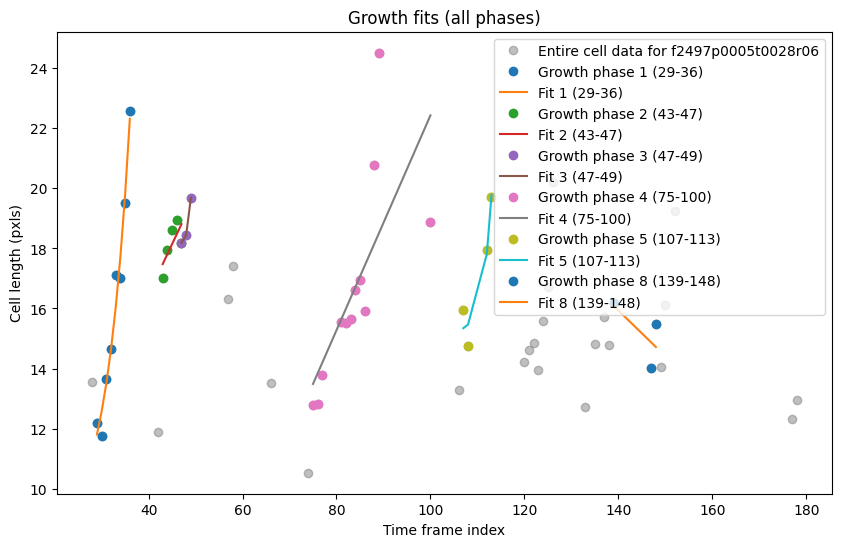

{'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64)}
No growth phases detected.


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

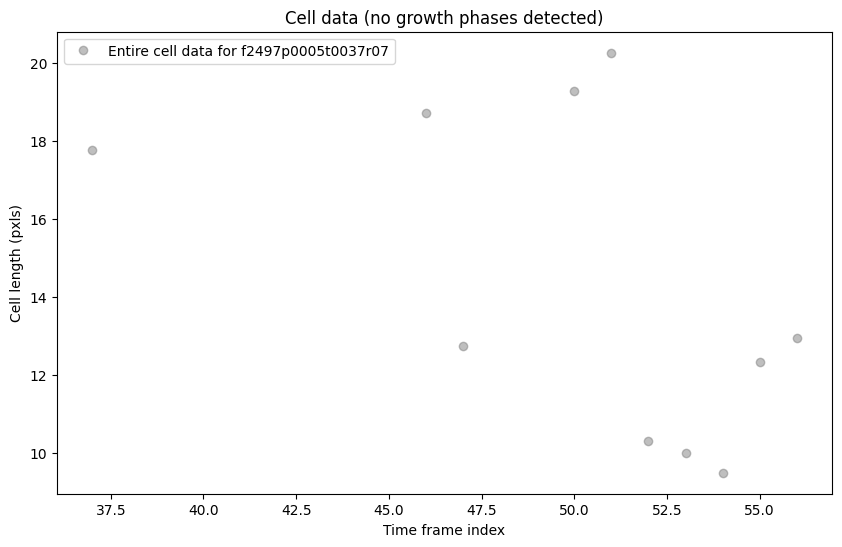

{'prominences': array([1.33815018, 0.74545994, 2.59257825]), 'left_bases': array([2, 5, 2]), 'right_bases': array([ 7,  7, 15])}
Fitting growth phase 1 from 99 to 129
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 1 (99-129)
Fitting growth phase 2 from 129 to 133
Error during curve fitting: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
  Fit failed for phase 2 (129-133)
Fitting growth phase 3 from 141 to 149
  Fit parameters: A=0.00, k=0.1975, b=9.96
  R-squared: 0.9280


/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['y_fit'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['residuals'] = np.nan
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_11312/267038356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

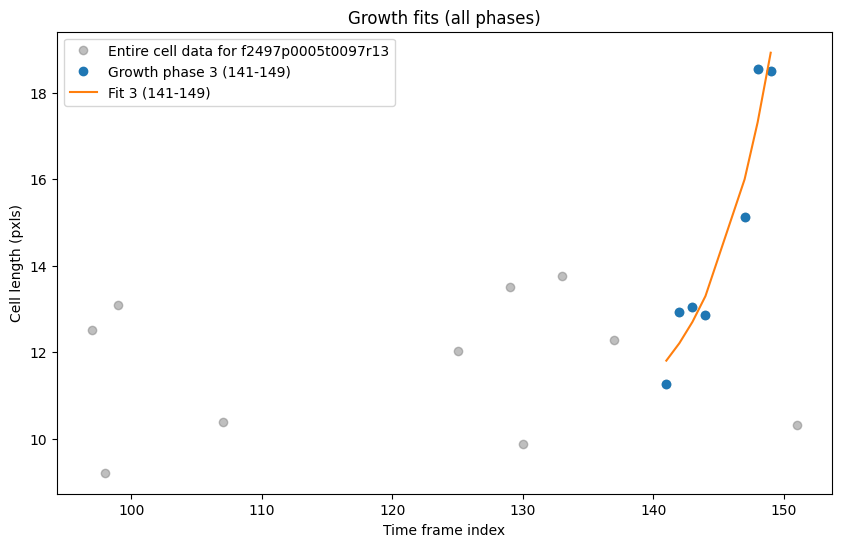

In [63]:
growth_all_cells_pd = pd.DataFrame()
for cell_id in all_cells_pd['cell_id'].unique():
    cell_df = all_cells_pd[all_cells_pd['cell_id'] == cell_id]
    growth_det = plot_growth_analysis(cell_df, cell_id, 'time_index', 'lengths_(pxls)', prominence=0.1, distance=3, window_size=3)
    if growth_all_cells_pd.empty:
        growth_all_cells_pd = growth_det 
    else:
        growth_all_cells_pd = pd.concat([growth_all_cells_pd, growth_det], ignore_index=True)

# Let's call the fits good enough...cluster based on residuals

In [67]:
cells_to_cluster_df = growth_all_cells_pd.dropna(subset=['residuals'])

In [68]:
cells_to_cluster_df

Unnamed: 0             cell_id  time_index  is_active daughters parent  \
14            14   f445p0005t0028r04          36      False       NaN    NaN   
15            15   f445p0005t0028r04          37      False       NaN    NaN   
16            16   f445p0005t0028r04          38      False       NaN    NaN   
17            17   f445p0005t0028r04          39      False       NaN    NaN   
18            18   f445p0005t0028r04          40      False       NaN    NaN   
...          ...                 ...         ...        ...       ...    ...   
1217        1217  f2497p0005t0097r13         143      False       NaN    NaN   
1218        1218  f2497p0005t0097r13         144      False       NaN    NaN   
1219        1219  f2497p0005t0097r13         147      False       NaN    NaN   
1220        1220  f2497p0005t0097r13         148      False       NaN    NaN   
1221        1221  f2497p0005t0097r13         149      False       NaN    NaN   

      labels             bboxes  areas_(pxls^2)  lengths_(pxls)  ...  \
14         5  (229, 5, 281, 15)           353.0       18.381347  ...   
15         5  (229, 6, 280, 16)           394.0       17.510247  ...   
16         5  (226, 6, 282, 16)           424.0       18.228217  ...   
17         5  (222, 6, 280, 16)           425.0       18.557722  ...   
18         5  (216, 5, 273, 15)           377.0       22.651922  ...   
...      ...                ...             ...             ...  ...   
1217      17   (61, 5, 102, 12)           215.0       13.055028  ...   
1218      17    (52, 5, 93, 11)           211.0       12.852582  ...   
1219      17   (70, 5, 115, 12)           228.0       15.122703  ...   
1220      17   (59, 5, 108, 11)           218.0       18.557990  ...   
1221      17   (51, 5, 102, 11)           238.0       18.495695  ...   

      orientations                                 centroids fl_area_avgs  \
14       -1.564159     (255.9943342776204, 9.88385269121813)          0.0   
15       -1.554984    (255.4289340101523, 10.98477157360406)          0.0   
16       -1.553859   (255.18632075471697, 10.93867924528302)          0.0   
17       -1.547652  (252.01176470588234, 10.774117647058823)          0.0   
18       -1.552954   (245.81697612732094, 9.607427055702917)          0.0   
...            ...                                       ...          ...   
1217      1.569446    (81.93488372093023, 7.888372093023256)          0.0   
1218     -1.566381   (71.90995260663507, 7.8246445497630335)          0.0   
1219      1.561474      (92.9342105263158, 8.00438596491228)          0.0   
1220      1.569553     (82.6651376146789, 8.142201834862385)          0.0   
1221      1.566360    (76.17647058823529, 8.021008403361344)          0.0   

                      experiment FOV  peak_id      y_fit  residuals  \
14    DUMM_giTG62_Glucose_012925   5      445  18.009388   0.371959   
15    DUMM_giTG62_Glucose_012925   5      445  18.016783  -0.506536   
16    DUMM_giTG62_Glucose_012925   5      445  18.077418   0.150800   
17    DUMM_giTG62_Glucose_012925   5      445  18.574597  -0.016875   
18    DUMM_giTG62_Glucose_012925   5      445  22.651270   0.000652   
...                          ...  ..      ...        ...        ...   
1217  DUMM_giTG62_Glucose_012925   5     2497  12.702071   0.352957   
1218  DUMM_giTG62_Glucose_012925   5     2497  13.300692  -0.448110   
1219  DUMM_giTG62_Glucose_012925   5     2497  16.001294  -0.878591   
1220  DUMM_giTG62_Glucose_012925   5     2497  17.320366   1.237624   
1221  DUMM_giTG62_Glucose_012925   5     2497  18.927484  -0.431790   

      r_squared              growth_phase  
14     0.974985    growth phase 1 (36-40)  
15     0.974985    growth phase 1 (36-40)  
16     0.974985    growth phase 1 (36-40)  
17     0.974985    growth phase 1 (36-40)  
18     0.974985    growth phase 1 (36-40)  
...         ...                       ...  
1217   0.928014  growth phase 3 (141-149)  
1218   0.928014  growth phase 3 (141-149)  
1219  

# separately process each growth phase

In [ ]:
linked_matrix, cell_ids, dendrogram_fig, dendrogram_ax = cluster_growth_traces(cells_to_cluster_df, 'cell_id', 'growth_phase', 'time_index', 'residuals', method='ward', metric='euclidean')

In [ ]:
if linked_matrix is not None:
    # Dendrogram with threshold lines
    dendrogram_dict = dendrogram(linked_matrix, orientation='top', labels=cell_ids, 
                                 distance_sort='descending', show_leaf_counts=True,  
                                 get_leaves=True, ax=dendrogram_ax)
    clusters = fcluster(linked_matrix, t=21, criterion='distance')
    all_cells_clustered = pd.merge(cells_to_cluster_df, cluster_df, on='cell_id', how='left')
    cell_colors = cell_color_dict(all_cells_clustered)

    for cluster_id in np.unique(clusters):
        cluster_data = all_cells_clustered[all_cells_clustered['cluster'] == cluster_id]
        if not cluster_data.empty:
            plt.figure(figsize=(10, 6))  # Adjust size
            for cell_id in cluster_data['cell_id'].unique():
                cell_data = cluster_data[cluster_data['cell_id'] == cell_id]
                for growth_phase_id in cell_data['growth_phase'].unique():
                    growth_df = cell_data[cell_data['growth_phase'] == growth_phase_id].copy()
                    plt.plot(growth_df['time_index'], growth_df['lengths_(pxls)'], 'o', label=f"Cell {cell_id}", color = cell_colors[cell_id])
                    plt.plot(growth_df['time_index'], growth_df['y_fit'], '-', label=f'Fit {growth_phase_id}', color = cell_colors[cell_id])
    
            plt.title(f"Cluster {cluster_id}")
            plt.xlabel("Time Index")
            plt.ylabel("Lengths (pxls)")
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside plot
            plt.tight_layout()
            plt.subplots_adjust(right=0.8) # Adjust layout for external legend
            plt.show()

else:
    print("Clustering failed. Check your data.")

In [ ]:
all_cells_clustered[all_cells_clustered['cell_id'] == 'f2497p0005t0028r06']

In [ ]:
all_cells_clustered[all_cells_clustered['cluster'] == 1]